# Rome AirBnB accommodation availability prediction

## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from shapely.geometry import Point
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, LeaveOneOut
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, roc_auc_score
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [2]:
pd.set_option('display.max_columns', None) #show all columns in our analysis

## Creating the rome_df dataframe

### Reading in the datasets from the .csv files

In [3]:
df_rome_lis = pd.read_csv("data\Rome\listings.csv")
df_rome_cal = pd.read_csv("data\Rome\calendar.csv")

In [4]:
df_rome_lis.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2737,https://www.airbnb.com/rooms/2737,20230907142203,2023-09-08,city scrape,Place to stay in Rome · ★4.80 · 1 bedroom · 1 ...,10 min by bus you can get to Piazza Venezia or...,It used to be an industrial area until late 80...,https://a0.muscache.com/pictures/41225252/e955...,3047,https://www.airbnb.com/users/show/3047,Elif,2008-09-18,"Rome, Italy",I am a Turkish-Italian who was born in Istanbu...,within a few hours,98%,3%,f,https://a0.muscache.com/im/pictures/user/a22d7...,https://a0.muscache.com/im/pictures/user/a22d7...,Testaccio,7,7,"['email', 'phone']",t,t,"Rome, Lazio, Italy",VIII Appia Antica,NaN,41.871360,12.482150,Private room,Private room,1,NaN,1.5 baths,NaN,1.0,"[""Hot tub"", ""Kitchen"", ""Wifi"", ""Dryer"", ""Eleva...",$75.00,7,1125,7,7,1125,1125,7.0,1125.0,NaN,t,23,53,83,358,2023-09-08,7,0,0,2014-12-26,2015-05-28,4.80,4.60,4.60,4.80,5.00,4.40,4.40,NaN,f,6,0,6,0,0.07
1,3079,https://www.airbnb.com/rooms/3079,20230907142203,2023-09-08,city scrape,Rental unit in Rome · ★4.53 · 1 bedroom · 1 be...,With the view of the Colisseum from the front ...,Monti neighborhood is one of the best areas in...,https://a0.muscache.com/pictures/e85b119c-3667...,3504,https://www.airbnb.com/users/show/3504,Laura,2008-10-08,"Rome, Italy",I've a degree in Art History\r\n,within a day,100%,10%,t,https://a0.muscache.com/im/users/3504/profile_...,https://a0.muscache.com/im/users/3504/profile_...,Monti,6,11,"['email', 'phone']",t,t,"Rome, Lazio, Italy",I Centro Storico,NaN,41.895000,12.491170,Entire rental unit,Entire home/apt,4,NaN,1 bath,1.0,1.0,"[""Essentials"", ""Kitchen"", ""Window AC unit"", ""D...",$90.00,20,120,20,20,120,120,20.0,120.0,NaN,t,1,1,1,130,2023-09-08,21,0,0,2011-01-02,2022-04-30,4.53,4.38,4.62,4.71,4.86,4.81,4.43,NaN,f,6,6,0,0,0.14
2,103245,https://www.airbnb.com/rooms/103245,20230907142203,2023-09-08,city scrape,Rental unit in Rome · ★4.87 · 2 bedrooms · 4 b...,"In the center of Rome, in the Trastevere distr...",Trastevere is a characteristic and original ne...,https://a0.muscache.com/pictures/805971/9aa629...,538724,https://www.airbnb.com/users/show/538724,Carla,2011-04-27,"Rome, Italy","Hello, I'm Carla, I am 55 years old. Me and my...",within an hour,100%,100%,t,https://a0.muscache.com/im/users/538724/profil...,https://a0.muscache.com/im/users/538724/profil...,Trastevere,1,1,"['email', 'phone']",t,t,"Rome, Lazio, Italy",I Centro Storico,NaN,41.887880,12.469750,Entire rental unit,Entire home/apt,6,NaN,1 bath,2.0,4.0,"[""Essentials"", ""Bathtub"", ""Kitchen"", ""Refriger...",$110.00,2,365,2,2,1125,1125,2.0,1125.0,NaN,t,2,4,18,266,2023-09-08,389,77,8,2011-05-19,2023-09-05,4.87,4.91,4.90,4.92,4.92,4.92,4.82,NaN,t,1,1,0,0,

In [5]:
df_rome_cal.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,103245,2023-09-08,f,$110.00,$110.00,2.0,1125.0
1,103245,2023-09-09,f,$110.00,$110.00,2.0,1125.0
2,103245,2023-09-10,f,$110.00,$110.00,2.0,1125.0
3,103245,2023-09-11,f,$110.00,$110.00,2.0,1125.0
4,103245,2023-09-12,t,$110.00,$110.00,2.0,1125.0


### Load the GeoJSON file into a GeoDataFrame

In [6]:
neighbourhoods_gdf = gpd.read_file('data/Rome/neighbourhoods.geojson')

In [7]:
neighbourhoods_gdf.head()

,neighbourhood,neighbourhood_group,geometry
0,I Centro Storico,NaN,"MULTIPOLYGON (((12.44396 41.93390, 12.44472 41..."
1,III Monte Sacro,NaN,"MULTIPOLYGON (((12.56321 42.07464, 12.56269 42..."
2,IV Tiburtina,NaN,"MULTIPOLYGON (((12.63542 41.95729, 12.63696 41..."
3,VI Roma delle Torri,NaN,"MULTIPOLYGON (((12.70671 41.93375, 12.70691 41..."
4,VII San Giovanni/Cinecittà,NaN,"MULTIPOLYGON (((12.51668 41.89194, 12.52266 41..."


### Keeping only the relevant columns

In [8]:
# Define the columns to keep
columns_to_keep_lis = ['id', 'host_response_time', 'host_response_rate', 'host_is_superhost', 'longitude', 'latitude', 'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds', 'amenities', 'number_of_reviews', 'review_scores_rating', 'instant_bookable']

# Select only the specified columns from the DataFrames
df_rome_lis = df_rome_lis[columns_to_keep_lis]

In [9]:
df_rome_lis.head()

,id,host_response_time,host_response_rate,host_is_superhost,longitude,latitude,property_type,room_type,accommodates,bedrooms,beds,amenities,number_of_reviews,review_scores_rating,instant_bookable
0,2737,within a few hours,98%,f,12.482150,41.871360,Private room,Private room,1,NaN,1.0,"[""Hot tub"", ""Kitchen"", ""Wifi"", ""Dryer"", ""Eleva...",7,4.80,f
1,3079,within a day,100%,t,12.491170,41.895000,Entire rental unit,Entire home/apt,4,1.0,1.0,"[""Essentials"", ""Kitchen"", ""Window AC unit"", ""D...",21,4.53,f
2,103245,within an hour,100%,t,12.469750,41.887880,Entire rental unit,Entire home/apt,6,2.0,4.0,"[""Essentials"", ""Bathtub"", ""Kitchen"", ""Refriger...",389,4.87,t
3,11834,within a few hours,100%,t,12.491181,41.895447,Entire rental unit,Entire home/apt,2,1.0,1.0,"[""Wine glasses"", ""Essentials"", ""Kitchen"", ""Pac...",203,4.81,f
4,103870,within an hour,100%,f,12.504230,41.897110,Entire rental unit,Entire home/apt,3,1.0,2.0,"[""Essentials"", ""Kitchen"", ""Refrigerator"", ""Loc...",289,4.18,t


### Merging the dataframes

In [10]:
# Rename the column in listings_df to match calendar_df for clarity
df_rome_lis.rename(columns={'id': 'listing_id'}, inplace=True)

# Merge the dataframes
rome_df_whole = pd.merge(df_rome_lis, df_rome_cal, on='listing_id', how='inner')

# Drop the listing_id column as is no use to use anymore
rome_df_whole.drop('listing_id', axis=1, inplace=True)

# Creating the same sample from the whole data set (for reproductibility)
rome_df = rome_df_whole.sample(frac=0.2, random_state=0)

In [11]:
rome_df.head()

,host_response_time,host_response_rate,host_is_superhost,longitude,latitude,property_type,room_type,accommodates,bedrooms,beds,amenities,number_of_reviews,review_scores_rating,instant_bookable,date,available,price,adjusted_price,minimum_nights,maximum_nights
5297582,NaN,NaN,f,12.52735,41.91412,Private room in rental unit,Private room,2,NaN,NaN,"[""Essentials"", ""Wifi"", ""Breakfast"", ""Shampoo"",...",0,NaN,f,2024-08-15,f,$50.00,$50.00,1.0,1125.0
6107468,within a day,100%,f,12.28825,41.73626,Entire condo,Entire home/apt,5,2.0,3.0,"[""Wine glasses"", ""Essentials"", ""Bathtub"", ""Kit...",8,4.38,t,2024-06-26,t,$116.00,$116.00,4.0,365.0
7776337,within an hour,100%,f,12.51805,41.89484,Entire condo,Entire home/apt,4,1.0,1.0,"[""Wine glasses"", ""Essentials"", ""Kitchen"", ""Sho...",1,5.00,t,2023-09-23,f,$222.00,$222.00,3.0,29.0
5312344,within an hour,100%,f,12.51292,41.85971,Entire home,Entire home/apt,10,6.0,8.0,"[""Essentials"", ""Kitchen"", ""Dryer"", ""Backyard"",...",0,NaN,t,2024-01-25,f,$800.00,$800.00,1.0,1125.0
6812494,within an hour,100%,t,12.49958,41.90353,Entire condo,Entire home/apt,5,2.0,3.0,"[""Wine glasses"", ""Essentials"", ""Kitchen"", ""Pac...",101,4.84,t,2024-01-25,t,$166.00,$166.00,2.0,1125.0


In [12]:
# Convert the longitude and latitude to a shapely Point() object
rome_df['geometry'] = rome_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Convert the df to a GeoDataFrame
gdf = gpd.GeoDataFrame(rome_df, geometry='geometry')

# Set the coordinate reference system (CRS) for df GeoDataFrame to WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Perform the spatial join
neighbourhoods_gdf = neighbourhoods_gdf.to_crs(gdf.crs)
joined_gdf = gpd.sjoin(gdf, neighbourhoods_gdf, how="left", predicate='intersects')

# Creating the 'neighbourhood' column in rome_df and copying the data from joined_gdf.neighbourhood collumn
rome_df['neighbourhood'] = joined_gdf['neighbourhood']

# Drop the geometry column as it's no longer needed
rome_df.drop(['geometry', 'latitude', 'longitude'], axis=1, inplace=True)

In [13]:
rome_df.describe().T

,count,mean,std,min,25%,50%,75%,max
accommodates,2045021.0,3.700331,2.063260e+00,1.0,2.00,4.0,4.00,1.600000e+01
bedrooms,1554551.0,1.615109,9.418941e-01,1.0,1.00,1.0,2.00,1.700000e+01
beds,2023995.0,2.226861,1.558389e+00,1.0,1.00,2.0,3.00,3.800000e+01
number_of_reviews,2045021.0,54.589656,8.773305e+01,0.0,3.00,18.0,67.00,1.731000e+03
review_scores_rating,1760153.0,4.694191,4.674009e-01,0.0,4.61,4.8,4.94,5.000000e+00
minimum_nights,2045020.0,3.440086,1.621032e+01,1.0,1.00,2.0,3.00,9.990000e+02
maximum_nights,2045020.0,497359.700467,3.265588e+07,1.0,90.00,999.0,1125.00,2.147484e+09


In [14]:
print (rome_df.isnull().sum())
print (rome_df.info())
rome_df.head()

host_response_time      265031
host_response_rate      265031
host_is_superhost        64835
property_type                0
room_type                    0
accommodates                 0
bedrooms                490470
beds                     21026
amenities                    0
number_of_reviews            0
review_scores_rating    284868
instant_bookable             0
date                         0
available                    0
price                       34
adjusted_price              34
minimum_nights               1
maximum_nights               1
neighbourhood                0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 2045021 entries, 5297582 to 9178184
Data columns (total 19 columns):
 #   Column                Dtype  
---  ------                -----  
 0   host_response_time    object 
 1   host_response_rate    object 
 2   host_is_superhost     object 
 3   property_type         object 
 4   room_type             object 
 5   accommodates          int64  
 6  

,host_response_time,host_response_rate,host_is_superhost,property_type,room_type,accommodates,bedrooms,beds,amenities,number_of_reviews,review_scores_rating,instant_bookable,date,available,price,adjusted_price,minimum_nights,maximum_nights,neighbourhood
5297582,NaN,NaN,f,Private room in rental unit,Private room,2,NaN,NaN,"[""Essentials"", ""Wifi"", ""Breakfast"", ""Shampoo"",...",0,NaN,f,2024-08-15,f,$50.00,$50.00,1.0,1125.0,II Parioli/Nomentano
6107468,within a day,100%,f,Entire condo,Entire home/apt,5,2.0,3.0,"[""Wine glasses"", ""Essentials"", ""Bathtub"", ""Kit...",8,4.38,t,2024-06-26,t,$116.00,$116.00,4.0,365.0,X Ostia/Acilia
7776337,within an hour,100%,f,Entire condo,Entire home/apt,4,1.0,1.0,"[""Wine glasses"", ""Essentials"", ""Kitchen"", ""Sho...",1,5.00,t,2023-09-23,f,$222.00,$222.00,3.0,29.0,II Parioli/Nomentano
5312344,within an hour,100%,f,Entire home,Entire home/apt,10,6.0,8.0,"[""Essentials"", ""Kitchen"", ""Dryer"", ""Backyard"",...",0,NaN,t,2024-01-25,f,$800.00,$800.00,1.0,1125.0,VIII Appia Antica
6812494,within an hour,100%,t,Entire condo,Entire home/apt,5,2.0,3.0,"[""Wine glasses"", ""Essentials"", ""Kitchen"", ""Pac...",101,4.84,t,2024-01-25,t,$166.00,$166.00,2.0,1125.0,I Centro Storico


## Data analysis and preparation

### Analysing price and adjusted_price features

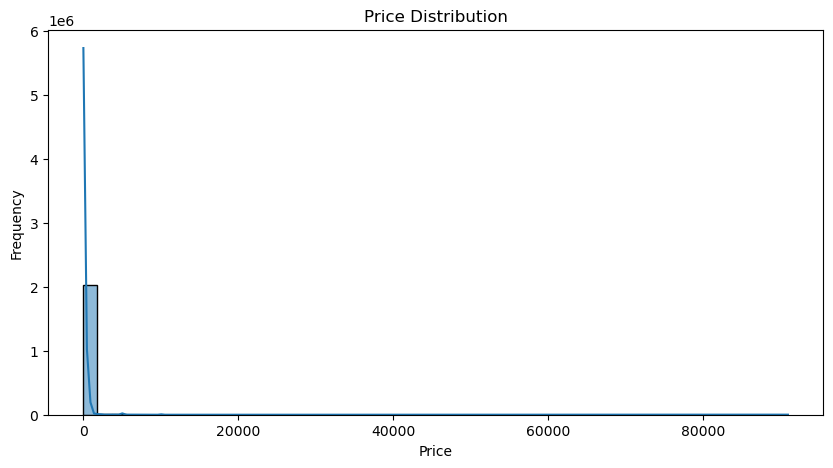

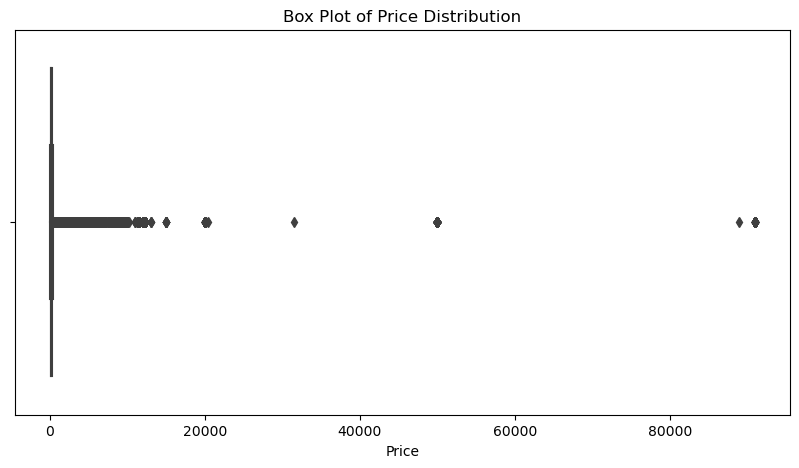

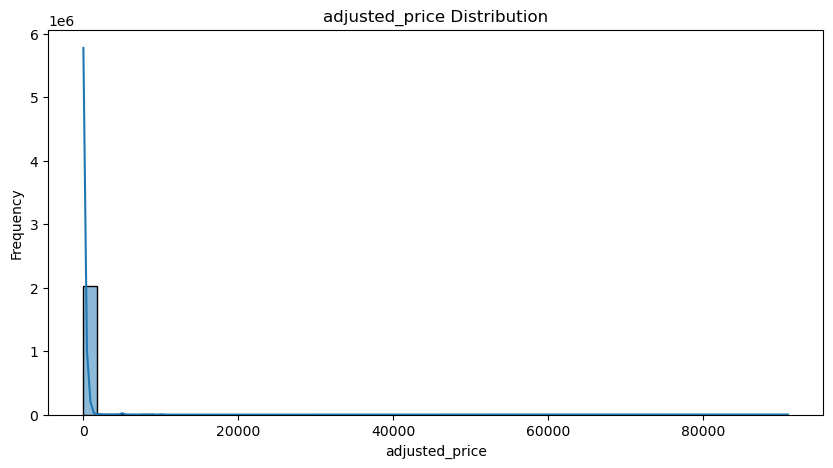

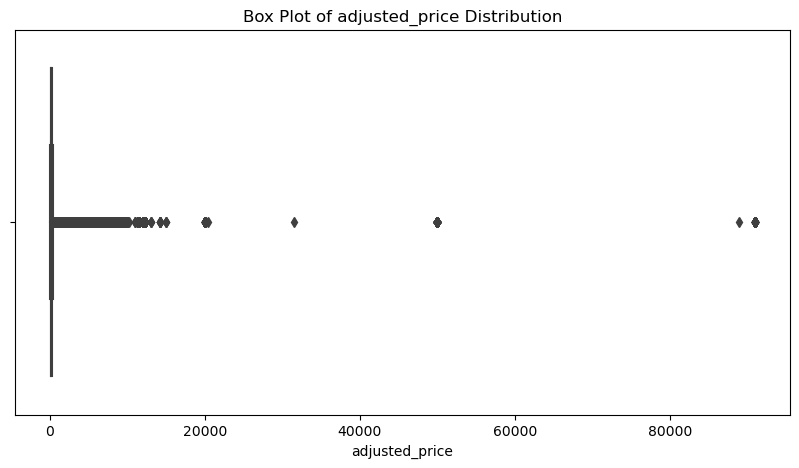

In [15]:
# Clean the 'price' and adjusted_price columns by removing dollar signs and converting to float
rome_df['price'] = rome_df['price'].replace('[\$,]', '', regex=True).astype('float32')
rome_df['adjusted_price'] = rome_df['adjusted_price'].replace('[\$,]', '', regex=True).astype('float32')

# Drop the NaN's (189 rows don't have the price listed in the whole dataset, so drop them if any selected)
rome_df = rome_df.dropna(subset=['price'])

# Histogram for price distribution
plt.figure(figsize=(10, 5))
sns.histplot(rome_df['price'], bins=50, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x=rome_df['price'])
plt.title('Box Plot of Price Distribution')
plt.xlabel('Price')
plt.show()

# Histogram for adjusted_price distribution
plt.figure(figsize=(10, 5))
sns.histplot(rome_df['adjusted_price'], bins=50, kde=True)
plt.title('adjusted_price Distribution')
plt.xlabel('adjusted_price')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x=rome_df['adjusted_price'])
plt.title('Box Plot of adjusted_price Distribution')
plt.xlabel('adjusted_price')
plt.show()

#### Removing outliners

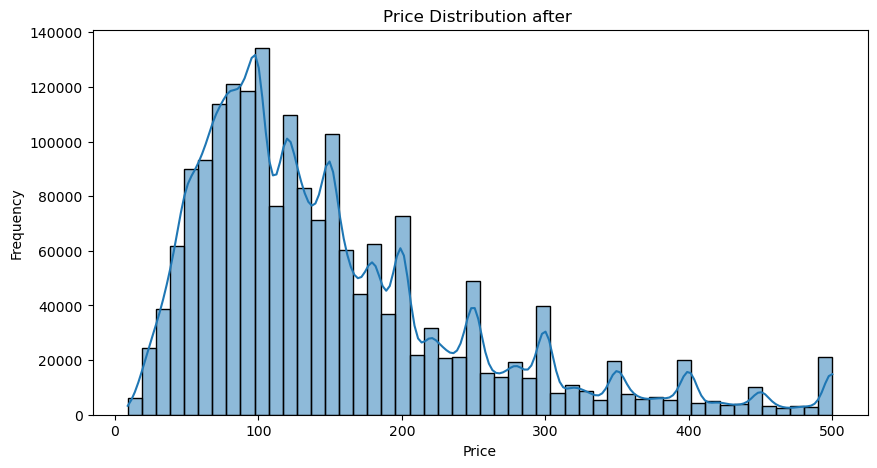

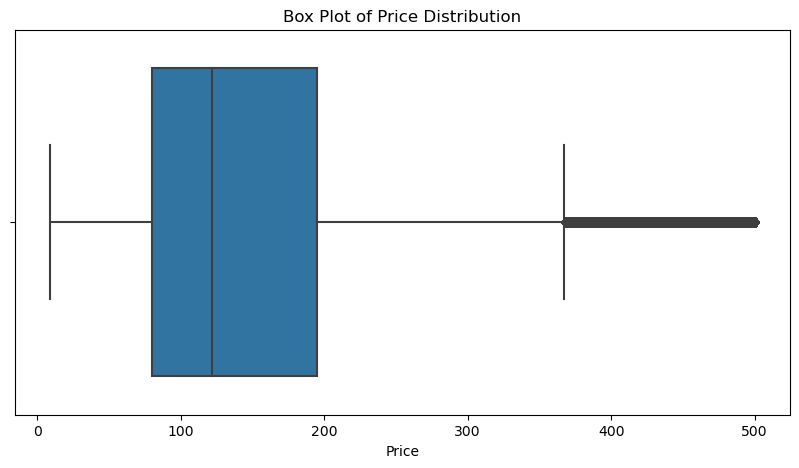

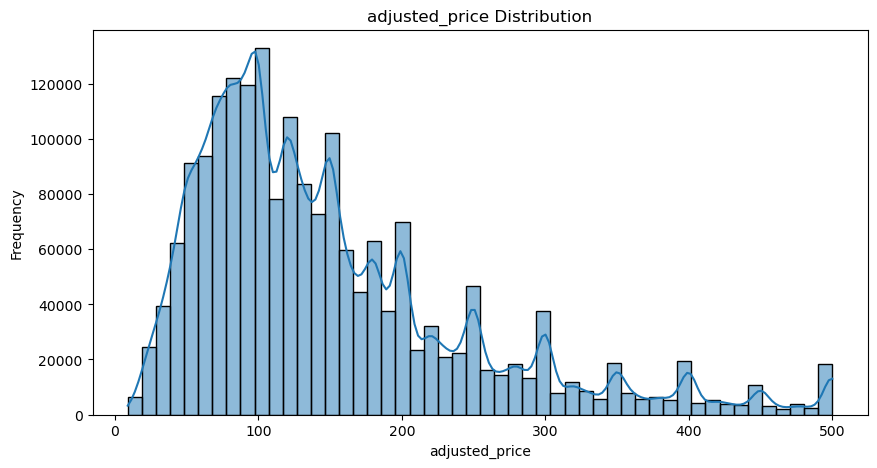

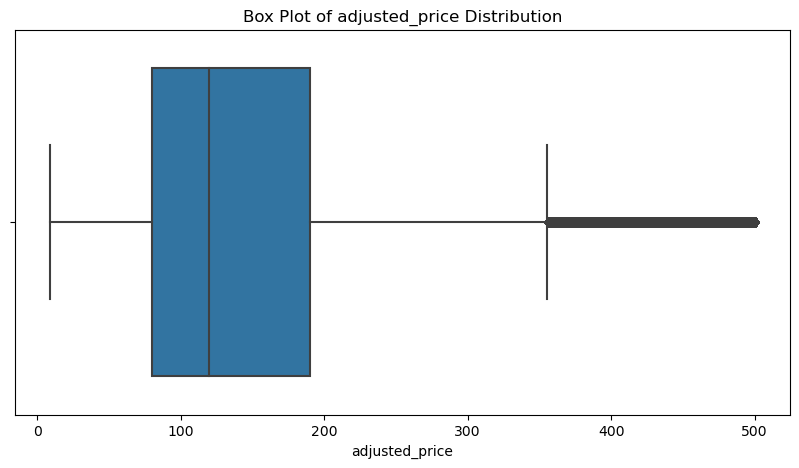

In [16]:
# Define the upper limit for capping
upper_limit_price = rome_df['price'].quantile(0.94)
upper_limit_adjusted_price = rome_df['adjusted_price'].quantile(0.94)

# Cap values at the 94th percentile
rome_df = rome_df[(rome_df['price'] <= upper_limit_price) & (rome_df['adjusted_price'] <= upper_limit_adjusted_price)]

# Histogram for price distribution
plt.figure(figsize=(10, 5))
sns.histplot(rome_df['price'], bins=50, kde=True)
plt.title('Price Distribution after ')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x=rome_df['price'])
plt.title('Box Plot of Price Distribution')
plt.xlabel('Price')
plt.show()

# Histogram for adjusted_price distribution
plt.figure(figsize=(10, 5))
sns.histplot(rome_df['adjusted_price'], bins=50, kde=True)
plt.title('adjusted_price Distribution')
plt.xlabel('adjusted_price')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x=rome_df['adjusted_price'])
plt.title('Box Plot of adjusted_price Distribution')
plt.xlabel('adjusted_price')
plt.show()

### Checking the difference in between price and the adjusted_price

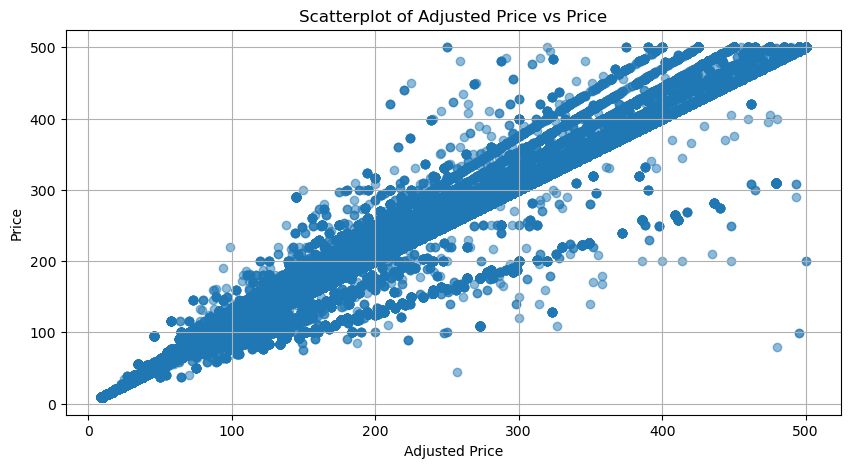

T-statistic: 192.3885318322266, P-value: 0.0


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


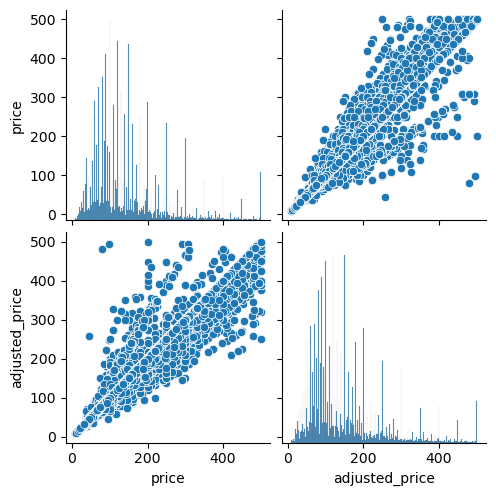

In [17]:
# Plotting scatterplots for 'adjusted_price' vs 'price'
plt.figure(figsize=(10, 5))
plt.scatter(rome_df['adjusted_price'], rome_df['price'], alpha=0.5)
plt.title('Scatterplot of Adjusted Price vs Price')
plt.xlabel('Adjusted Price')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# The t-test shows a significant difference between 'price' and 'adjusted_price' columns,
# suggesting they are not equivalent.
t_stat, p_value = stats.ttest_rel(rome_df['price'], rome_df['adjusted_price'])
print(f"T-statistic: {t_stat}, P-value: {p_value}")

sns.pairplot(rome_df[['price', 'adjusted_price']])
plt.show()

#### Deriving two new features from the adjusted_price column

In [18]:
# Create a new column 'given_discount' where it's 1 if 'adjusted_price' < 'price', else 0
rome_df['given_discount'] = (rome_df['adjusted_price'] < rome_df['price']).astype(int)

# Create a new column 'increased_price' where it's 1 if 'adjusted_price' > 'price', else 0
rome_df['increased_price'] = (rome_df['adjusted_price'] > rome_df['price']).astype(int)

# Drop the 'price_adjusted' column if it's no longer needed
rome_df.drop('adjusted_price', axis=1, inplace=True)

# Count the number of rows with a given discount
given_discount_count = rome_df['given_discount'].sum()

# Count the number of rows with an increased price
increased_price_count = rome_df['increased_price'].sum()

print(f"Count of given discounts: {given_discount_count}")
print(f"Count of increased prices: {increased_price_count}")

Count of given discounts: 134692
Count of increased prices: 5296


### Checking the host_response_time and host_response_rate

#### Visualising the data

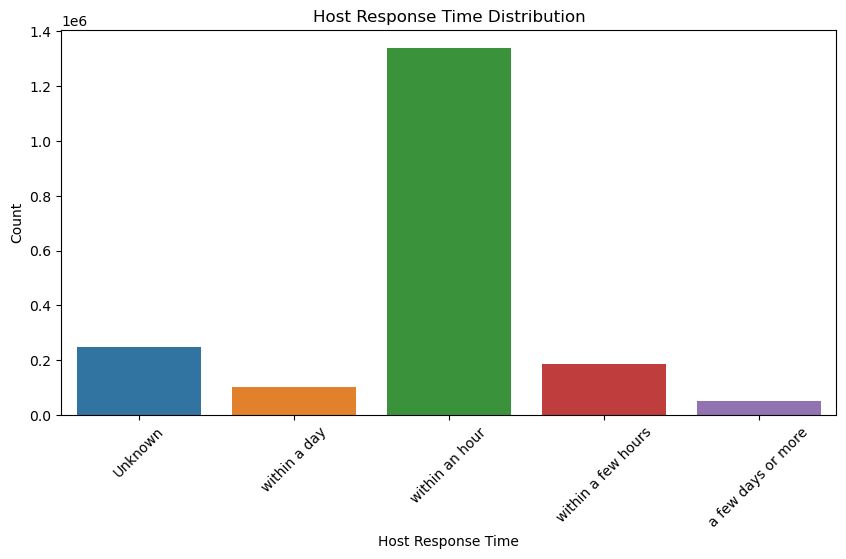

In [19]:
rome_df['host_response_time'].fillna('Unknown', inplace=True)

# Count plot for categorical data like host_response_time
plt.figure(figsize=(10, 5))
sns.countplot(x='host_response_time', data=rome_df)
plt.title('Host Response Time Distribution')
plt.xlabel('Host Response Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

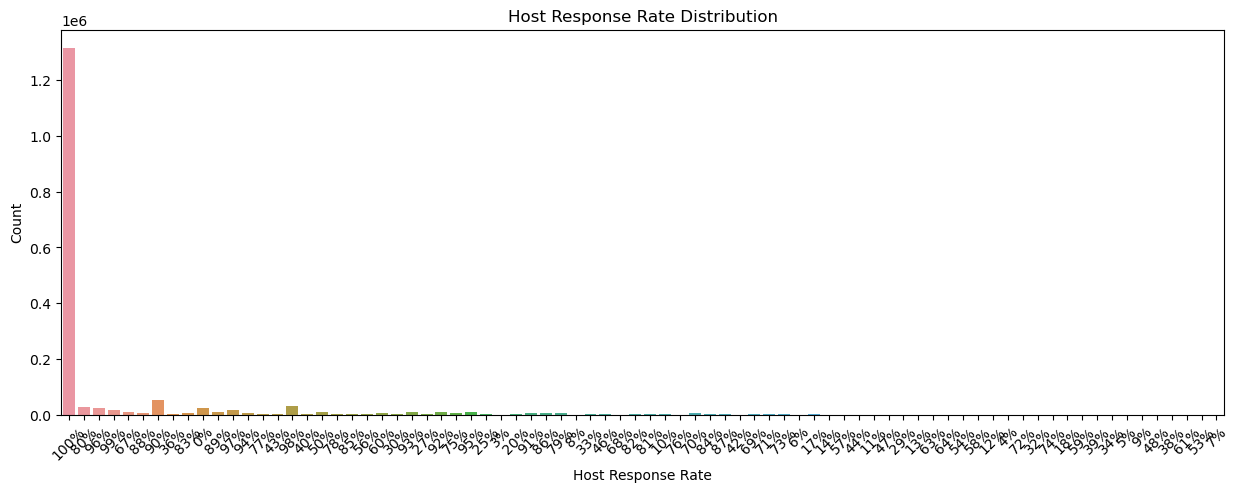

In [20]:
# Count plot for categorical data host_response_rate
plt.figure(figsize=(15, 5))
sns.countplot(x='host_response_rate', data=rome_df)
plt.title('Host Response Rate Distribution')
plt.xlabel('Host Response Rate')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [21]:
# Drop the 'host_response_rate' column, as most of the values are 100% or close
rome_df.drop('host_response_rate', axis=1, inplace=True)

### Checking host_is_superhost column

In [22]:
nan_host_is_superhost = rome_df[rome_df['host_is_superhost'].isna()] 
nan_host_is_superhost.head()

,host_response_time,host_is_superhost,property_type,room_type,accommodates,bedrooms,beds,amenities,number_of_reviews,review_scores_rating,instant_bookable,date,available,price,minimum_nights,maximum_nights,neighbourhood,given_discount,increased_price
8548694,within an hour,NaN,Entire condo,Entire home/apt,7,4.0,4.0,"[""Wine glasses"", ""Essentials"", ""Coffee maker: ...",6,5.00,f,2023-10-10,t,300.0,2.0,1125.0,I Centro Storico,0,0
7367523,within an hour,NaN,Entire condo,Entire home/apt,2,1.0,2.0,"[""Wine glasses"", ""Essentials"", ""Kitchen"", ""Win...",35,4.71,t,2023-09-09,f,117.0,1.0,1125.0,I Centro Storico,0,0
7327893,Unknown,NaN,Private room in condo,Private room,4,NaN,3.0,"[""Essentials"", ""Body soap"", ""Bidet"", ""Shampoo""...",0,NaN,f,2024-02-11,t,180.0,3.0,365.0,I Centro Storico,0,0
8154564,within an hour,NaN,Entire rental unit,Entire home/apt,6,3.0,3.0,"[""Wine glasses"", ""Essentials"", ""Bathtub"", ""Kit...",48,4.96,t,2023-12-19,t,190.0,1.0,1125.0,I Centro Storico,1,0
5305276,within an hour,NaN,Private room in serviced apartment,Private room,2,1.0,1.0,"[""Essentials"", ""Shower gel"", ""Room-darkening s...",128,4.93,t,2023-09-14,f,118.0,2.0,30.0,XIV Monte Mario,0,0


#### We fill in the Nan values in host_is_superhost column with its mode

In [23]:
rome_df['host_is_superhost'].fillna(rome_df['host_is_superhost'].mode()[0], inplace=True)

### Checking 'accommodates', 'bedrooms', and 'beds' column

In [24]:
# Print the counts of null values for specific columns
columns_of_interest = ['property_type', 'room_type', 'accommodates', 'bedrooms', 'beds']
null_counts = rome_df[columns_of_interest].isnull().sum()
print("Null Counts:\n", null_counts)

# Print the descriptive statistics for these columns
print("\nDescriptive Statistics:\n", rome_df[columns_of_interest].describe())

# Print 10 rows where 'bedrooms' is null
print("\nRows where 'bedrooms' is null:\n", rome_df[rome_df['bedrooms'].isnull()][columns_of_interest].head(10))

Null Counts:
 property_type         0
room_type             0
accommodates          0
bedrooms         481067
beds              19154
dtype: int64

Descriptive Statistics:
        accommodates      bedrooms          beds
count  1.925317e+06  1.444250e+06  1.906163e+06
mean   3.551752e+00  1.543064e+00  2.139132e+00
std    1.825993e+00  8.145351e-01  1.385463e+00
min    1.000000e+00  1.000000e+00  1.000000e+00
25%    2.000000e+00  1.000000e+00  1.000000e+00
50%    3.000000e+00  1.000000e+00  2.000000e+00
75%    4.000000e+00  2.000000e+00  3.000000e+00
max    1.600000e+01  1.600000e+01  2.400000e+01

Rows where 'bedrooms' is null:
                              property_type        room_type  accommodates  \
5297582        Private room in rental unit     Private room             2   
2657421               Private room in home     Private room             1   
5836535  Private room in bed and breakfast     Private room             2   
4537704                 Entire rental unit  Entire hom

#### Check distribution

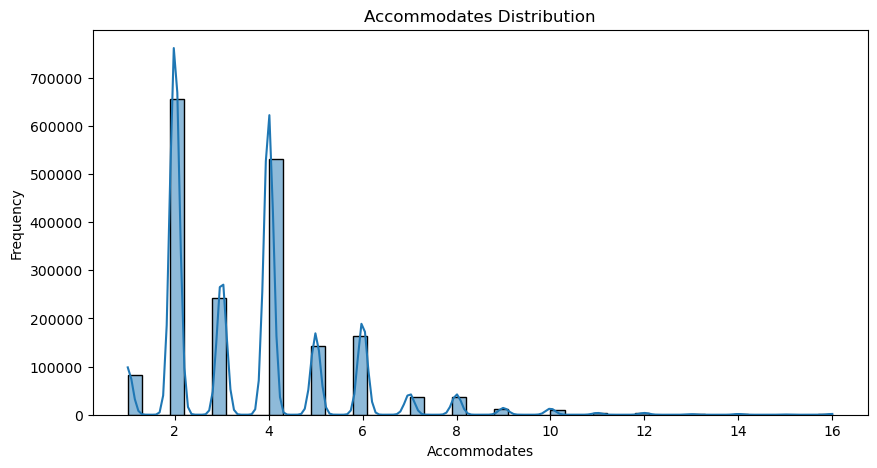

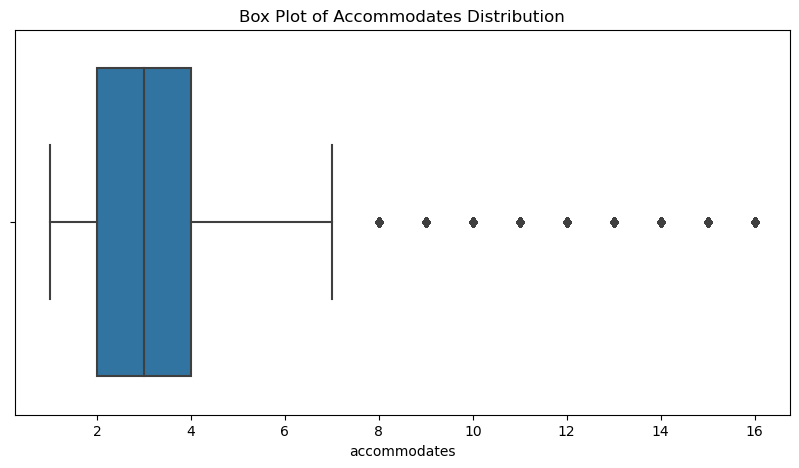

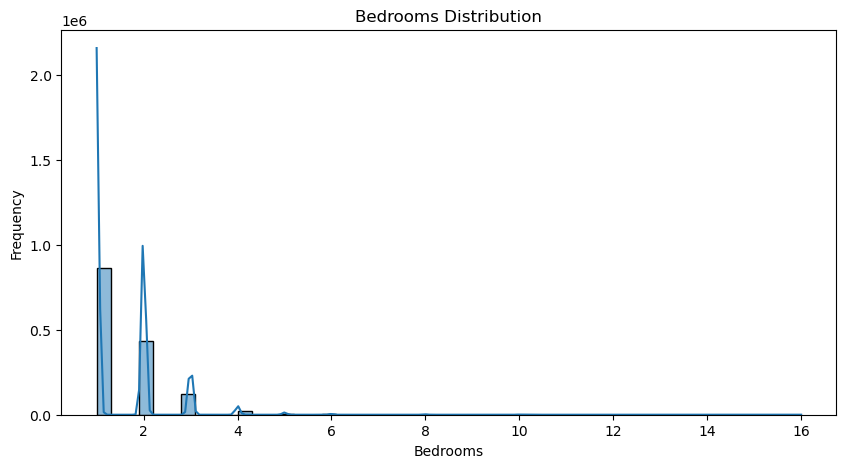

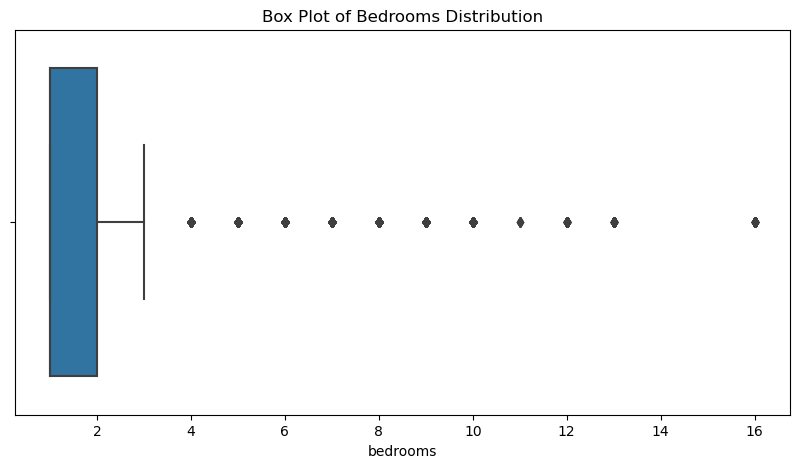

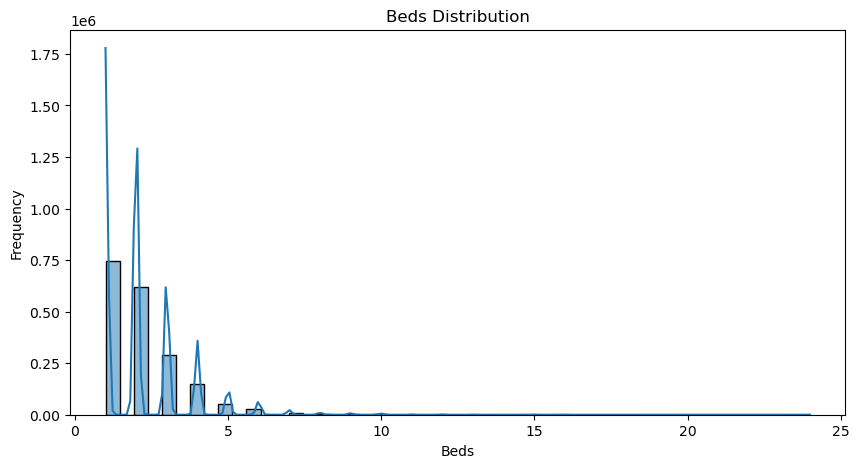

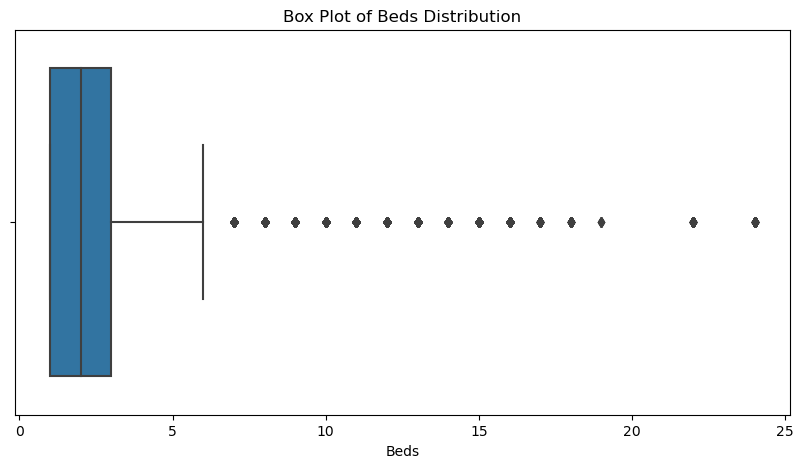

In [25]:
# Histogram for accommodates distribution
plt.figure(figsize=(10, 5))
sns.histplot(rome_df['accommodates'], bins=50, kde=True)
plt.title('Accommodates Distribution')
plt.xlabel('Accommodates')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x=rome_df['accommodates'])
plt.title('Box Plot of Accommodates Distribution')
plt.xlabel('accommodates')
plt.show()

# Histogram for bedrooms distribution
plt.figure(figsize=(10, 5))
sns.histplot(rome_df['bedrooms'], bins=50, kde=True)
plt.title('Bedrooms Distribution')
plt.xlabel('Bedrooms')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x=rome_df['bedrooms'])
plt.title('Box Plot of Bedrooms Distribution')
plt.xlabel('bedrooms')
plt.show()

# Histogram for beds distribution
plt.figure(figsize=(10, 5))
sns.histplot(rome_df['beds'], bins=50, kde=True)
plt.title('Beds Distribution')
plt.xlabel('Beds')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x=rome_df['beds'])
plt.title('Box Plot of Beds Distribution')
plt.xlabel('Beds')
plt.show()

#### Removing the outliners

In [26]:
# Define the upper limit for capping
upper_limit_accommodates = rome_df['accommodates'].quantile(0.95)
upper_limit_bedrooms = rome_df['bedrooms'].quantile(0.95)
upper_limit_beds = rome_df['beds'].quantile(0.95)

# Cap values at the 95th percentile
rome_df = rome_df[(rome_df['accommodates'] <= upper_limit_accommodates) 
                  & (rome_df['bedrooms'] <= upper_limit_bedrooms) 
                  & (rome_df['beds'] <= upper_limit_beds)]

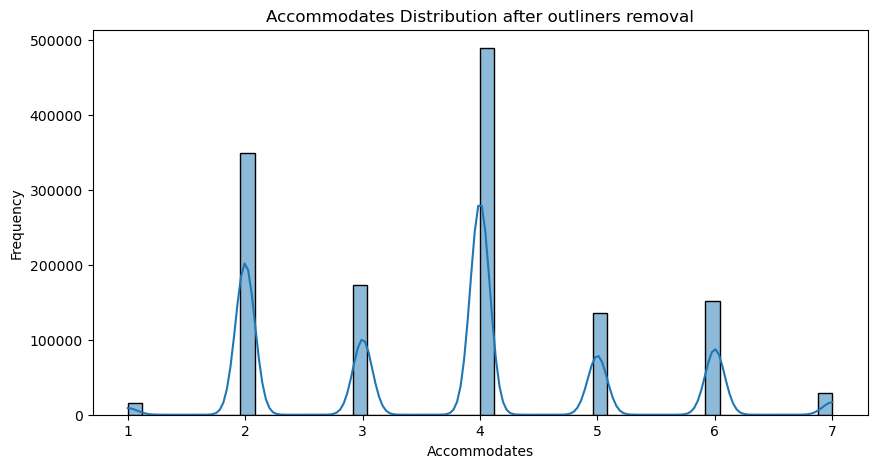

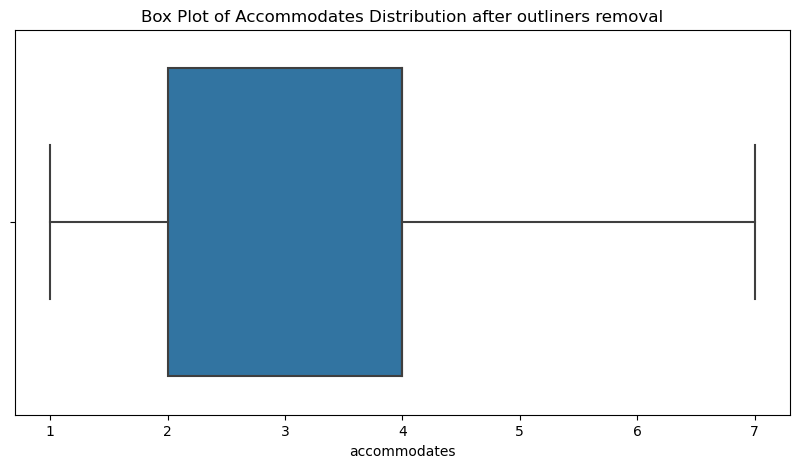

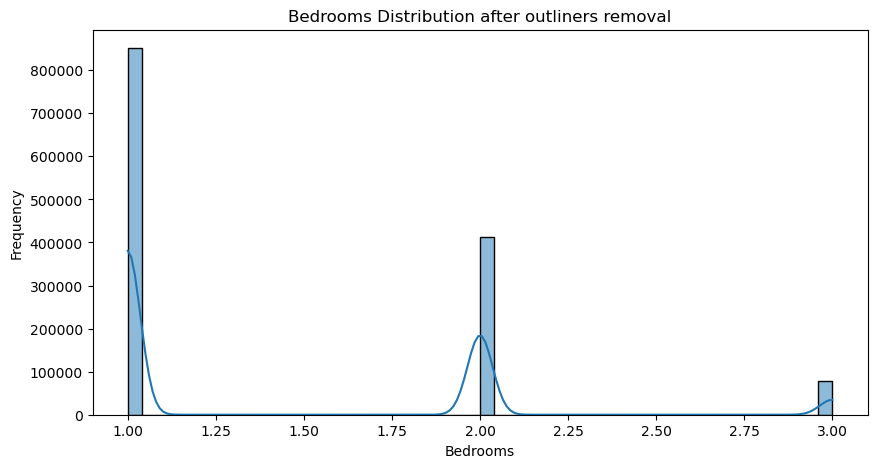

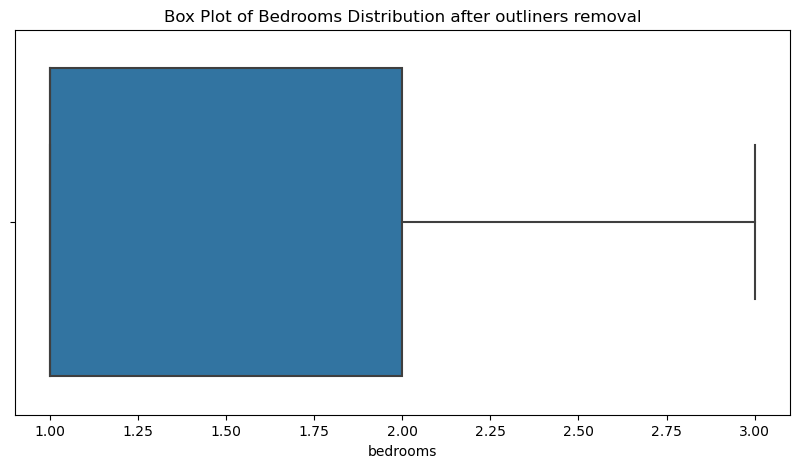

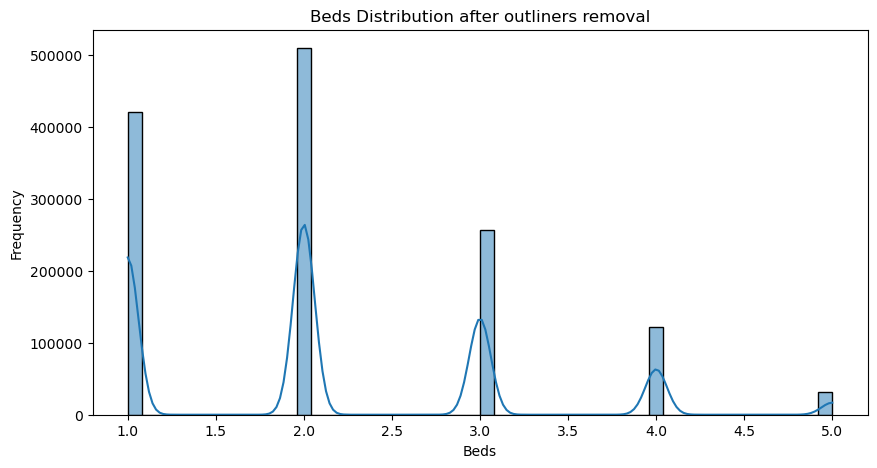

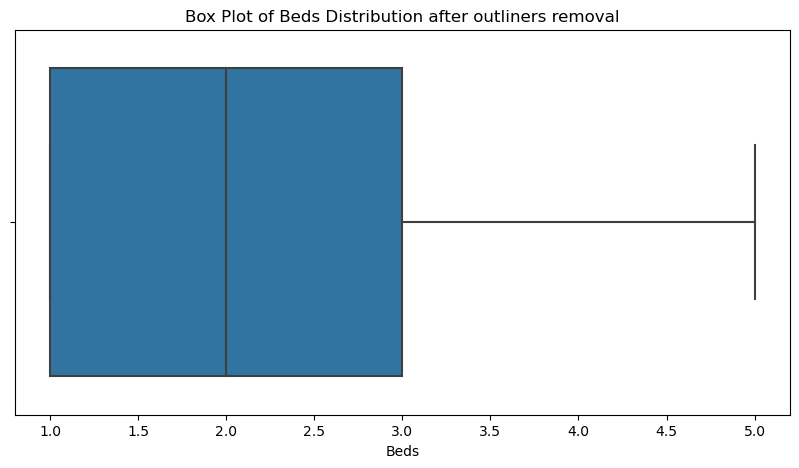

In [27]:
# Histogram for accommodates distribution after outliners removal
plt.figure(figsize=(10, 5))
sns.histplot(rome_df['accommodates'], bins=50, kde=True)
plt.title('Accommodates Distribution after outliners removal')
plt.xlabel('Accommodates')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x=rome_df['accommodates'])
plt.title('Box Plot of Accommodates Distribution after outliners removal')
plt.xlabel('accommodates')
plt.show()

# Histogram for bedrooms distribution after outliners removal
plt.figure(figsize=(10, 5))
sns.histplot(rome_df['bedrooms'], bins=50, kde=True)
plt.title('Bedrooms Distribution after outliners removal')
plt.xlabel('Bedrooms')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x=rome_df['bedrooms'])
plt.title('Box Plot of Bedrooms Distribution after outliners removal')
plt.xlabel('bedrooms')
plt.show()

# Histogram for beds distribution after outliners removal
plt.figure(figsize=(10, 5))
sns.histplot(rome_df['beds'], bins=50, kde=True)
plt.title('Beds Distribution after outliners removal')
plt.xlabel('Beds')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x=rome_df['beds'])
plt.title('Box Plot of Beds Distribution after outliners removal')
plt.xlabel('Beds')
plt.show()

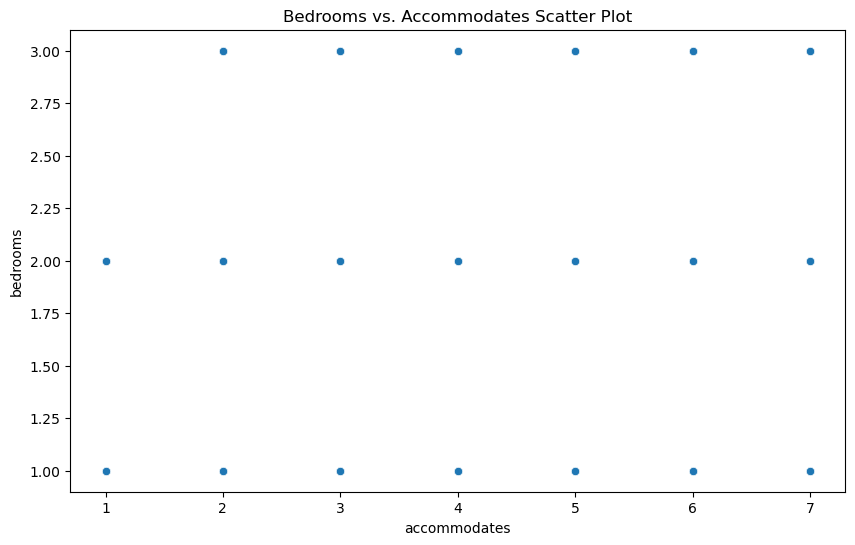

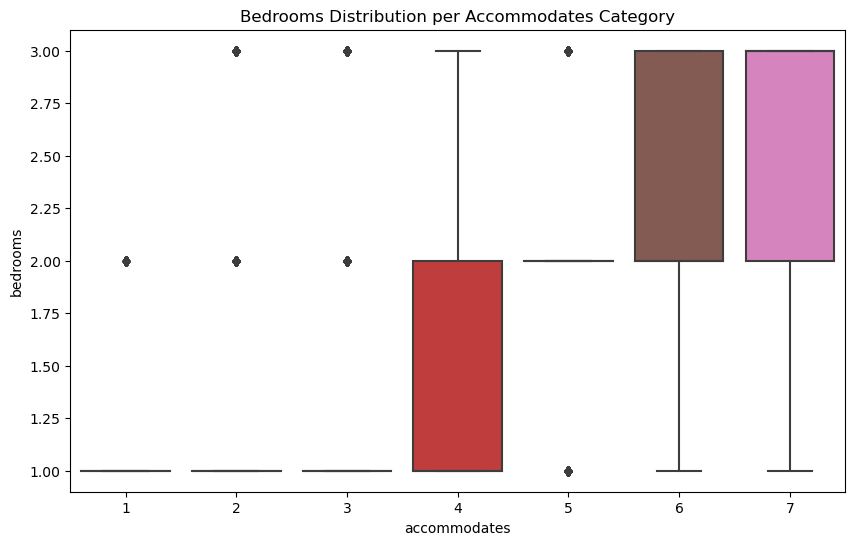

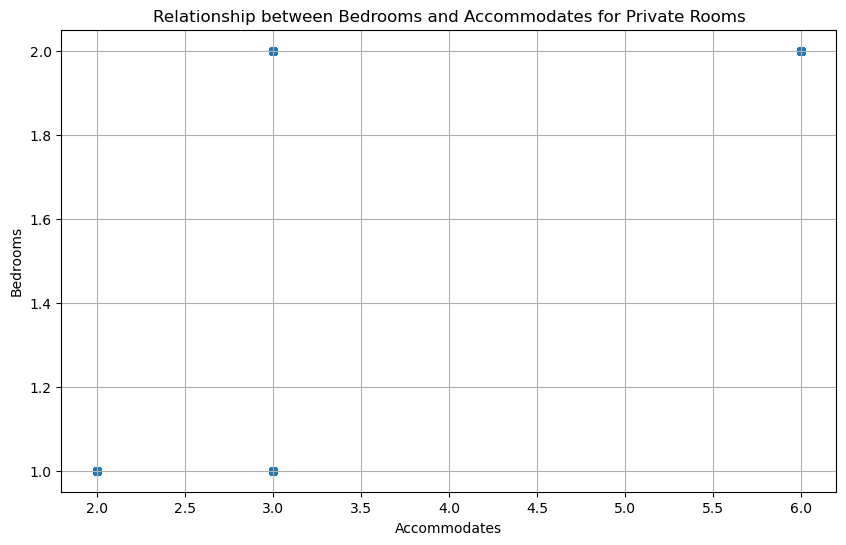

In [28]:
# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rome_df, x='accommodates', y='bedrooms')
plt.title('Bedrooms vs. Accommodates Scatter Plot')
plt.show()

# Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=rome_df, x='accommodates', y='bedrooms')
plt.title('Bedrooms Distribution per Accommodates Category')
plt.show()

# Filter the DataFrame for rows where property_type is 'Private room'
private_rooms = rome_df[rome_df['property_type'] == 'Private room']

# Create a scatter plot for 'bedrooms' vs 'accommodates' columns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=private_rooms, x='accommodates', y='bedrooms', alpha=0.6, edgecolor=None)
plt.title('Relationship between Bedrooms and Accommodates for Private Rooms')
plt.xlabel('Accommodates')
plt.ylabel('Bedrooms')
plt.grid(True)
plt.show()

#### Inspecting strange data

In [29]:
# Filter rows where 'accommodates' is 10 and 'bedrooms' is 1
weird_rows = rome_df[(rome_df['accommodates'] == 10) & (rome_df['bedrooms'] == 1)]

# Count rows where 'accommodates' is less than 'bedrooms'
count_weird_rows = rome_df[rome_df['accommodates'] < rome_df['bedrooms']].shape[0]

# Print the count
print(f"Number of rows where accommodates is less than bedrooms: {count_weird_rows}")

weird_rows.head(100)

Number of rows where accommodates is less than bedrooms: 1607


,host_response_time,host_is_superhost,property_type,room_type,accommodates,bedrooms,beds,amenities,number_of_reviews,review_scores_rating,instant_bookable,date,available,price,minimum_nights,maximum_nights,neighbourhood,given_discount,increased_price


In [30]:
# Define the outlier conditions
condition1 = (rome_df['accommodates'] < rome_df['bedrooms'] )
condition2 = (rome_df['accommodates'] == 10) & (rome_df['bedrooms'] == 1)

# Combine the conditions
combined_condition = condition1 | condition2

# Use the ~ operator to negate the combined condition and filter the DataFrame
rome_df = rome_df[~combined_condition]

#### Estimating the number of bedrooms based on 'accommodates' and 'property_type' columns and then fill the NaN's

In [31]:
# Ensure correct data types
rome_df['accommodates'] = rome_df['accommodates'].astype(int)
rome_df['property_type'] = rome_df['property_type'].astype(str)
rome_df['bedrooms'] = rome_df['bedrooms'].astype(float)

# Vectorized function to estimate bedrooms
def estimate_bedrooms(accommodates, property_type, current_bedrooms):
    # If bedrooms are already present, just return them
    bedrooms = current_bedrooms.copy()
    
    # Estimate bedrooms only where they are NaN
    mask = bedrooms.isna()
    
    # All private accomodations get 1 bedroom
    bedrooms[mask & (property_type == 'Private room')] = 1
    
    # Non-private accomodations with accommodates <= 3 get 1 bedroom
    bedrooms[mask & (accommodates <= 3) & (property_type != 'Private room')] = 1
    
    # Non-private accomodations with accommodates == 4 get 2 bedrooms
    bedrooms[mask & (accommodates == 4) & (property_type != 'Private room')] = 2
    
    # Non-private accomodations with accommodates == 5 get 2 bedrooms
    bedrooms[mask & (accommodates == 5) & (property_type != 'Private room')] = 2
    
    # Accommodates == 6 gets 3 bedrooms
    bedrooms[mask & (accommodates == 6)] = 3
    
    # Other cases get accommodates divided by 2, rounded up
    bedrooms[mask & (accommodates > 6)] = np.ceil(accommodates[mask & (accommodates > 6)] / 2.0)
    
    return bedrooms

# Apply the vectorized function to estimate bedrooms
rome_df['bedrooms'] = estimate_bedrooms(rome_df['accommodates'], rome_df['property_type'], rome_df['bedrooms'])

#### Filling the NaN's in 'beds' based on the number of people an accomodation can host

In [32]:
def estimate_beds(row):
    if pd.isnull(row['beds']):
        if row['accommodates'] == 1:
            return 1
        elif row['accommodates'] == 2:
            return 1
        elif row['accommodates'] == 3:
            return 2
        elif row['accommodates'] == 4:
            return 2
        elif row['accommodates'] == 5:
            return 3
        elif row['accommodates'] == 6:
            return 3
        elif row['accommodates'] == 7:
            return 4
        elif row['accommodates'] == 8:
            return 4
    else:
        return row['beds']

# Apply the function to the DataFrame
rome_df['beds'] = rome_df.apply(estimate_beds, axis=1)

## Filling NaN's in review_scores_rating with 0

In [33]:
rome_df.review_scores_rating = rome_df.review_scores_rating.fillna(0)

## Dropping the few rows having minimum_nights as NaN

In [34]:
rome_df = rome_df.dropna(subset=['minimum_nights'])

## Extracting day of the year feature from date

In [35]:
# Convert date to datetime
rome_df['date'] = pd.to_datetime(rome_df['date'])

# Extracting features
rome_df['day_of_year'] = rome_df['date'].dt.dayofyear

# Dropping the date column
rome_df.drop('date', axis=1, inplace=True)

## Mapping the host_response_time to an ordinal scale with a meaningul order

In [36]:
# Map the ordinal feature 'host_response_time' to an ordinal scale
response_time_mapping = {
    'within an hour': 4,
    'within a few hours': 3,
    'within a day': 2,
    'a few days or more': 1,
    'Unknown': 0
}

rome_df['host_response_time'] = rome_df['host_response_time'].map(response_time_mapping)

## Encode 'property_type' and 'room_type'

In [37]:
# List of columns to encode
columns_to_encode = ['neighbourhood', 'host_is_superhost', 'instant_bookable', 
                     'property_type', 'room_type', 'available']

le = LabelEncoder()

# Loop through each column and apply LabelEncoder
for column in columns_to_encode:
    rome_df[column] = le.fit_transform(rome_df[column])

## Handling 'amenities' column

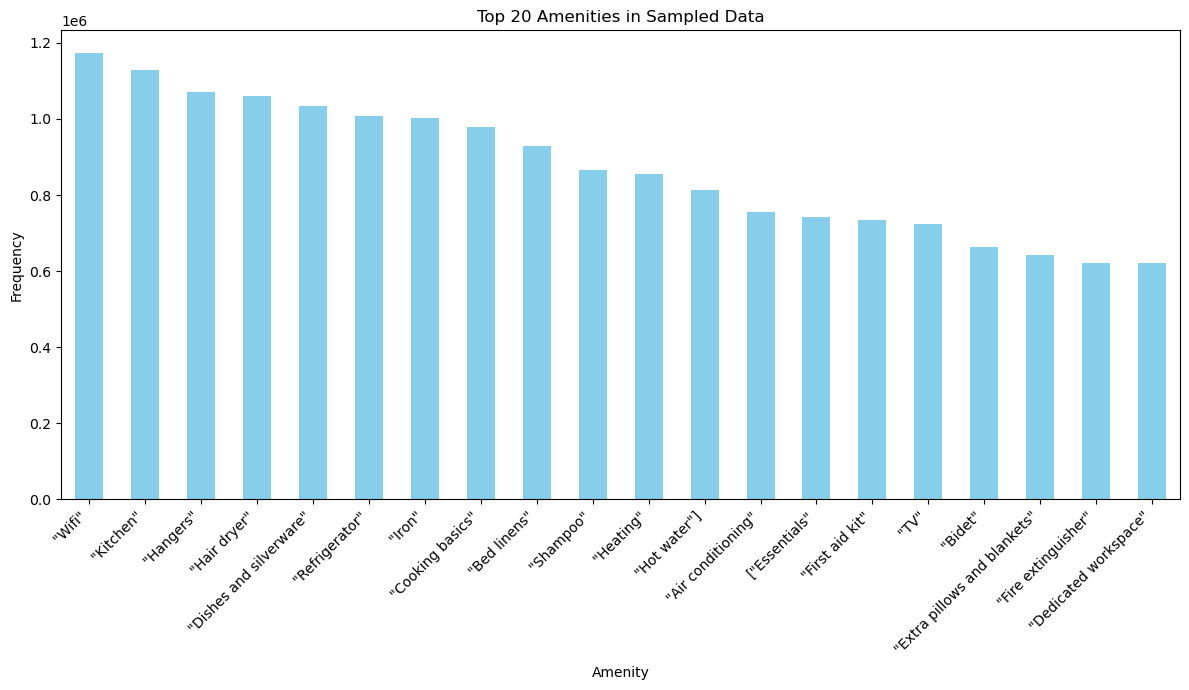

In [38]:
# Split the content in amenities column by commas and save into series object
amenities_series = rome_df['amenities'].str.split(',')

# Flatten the list of lists into a single list of amenities
all_amenities = [amenity for sublist in amenities_series for amenity in sublist]

# Create a DataFrame from the amenities list
amenities_df = pd.DataFrame(all_amenities, columns=['amenity'])

# Count the occurrences of each amenity
amenity_counts = amenities_df['amenity'].value_counts()

# Visualize the top 20 amenities
amenity_counts.head(20).plot(kind='bar', figsize=(12, 7), color='skyblue')

plt.title('Top 20 Amenities in Sampled Data')
plt.xlabel('Amenity')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Selecting top 5 amenities and encoding them as categorical features

In [39]:
# Save the top 5 amenities in a list
top_5_amenities = amenity_counts.head(5).index.tolist()

# Clean the top 5 amenities by stripping extra spaces and quotes
top_5_amenities = [amenity.strip(' "').strip("'") for amenity in top_5_amenities]

# Print cleaned top 5 amenities
print("Cleaned Top 5 amenities:", top_5_amenities)

# Clean the amenities in the dataframe
rome_df['amenities'] = rome_df['amenities'].apply(
    lambda x: [amenity.strip(' "').strip("'") for amenity in x.split(',')]
)

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Filter the amenities in rome_df to only include the top 5
rome_df['top_amenities'] = rome_df['amenities'].apply(
    lambda x: [amenity for amenity in x if amenity in top_5_amenities]
)

# Fit and transform the 'top_amenities' column
amenities_encoded = mlb.fit_transform(rome_df['top_amenities'])

# Create a DataFrame from the encoded amenities
top_amenities_df = pd.DataFrame(amenities_encoded, columns=mlb.classes_)

# Concatenate the new DataFrame with the original one (making sure indexes are aligned)
rome_df = pd.concat([rome_df.reset_index(drop=True), top_amenities_df.reset_index(drop=True)], axis=1)

# Drop the original 'amenities' and 'top_amenities' columns as they are no longer needed
rome_df.drop(['amenities', 'top_amenities'], axis=1, inplace=True)

# Print DataFrame information after dropping unnecessary columns
print("\nDataFrame after dropping 'amenities' and 'top_amenities':")
print(rome_df.info())

Cleaned Top 5 amenities: ['Wifi', 'Kitchen', 'Hangers', 'Hair dryer', 'Dishes and silverware']

DataFrame after dropping 'amenities' and 'top_amenities':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339994 entries, 0 to 1339993
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   host_response_time     1339994 non-null  int64  
 1   host_is_superhost      1339994 non-null  int32  
 2   property_type          1339994 non-null  int32  
 3   room_type              1339994 non-null  int32  
 4   accommodates           1339994 non-null  int32  
 5   bedrooms               1339994 non-null  float64
 6   beds                   1339994 non-null  float64
 7   number_of_reviews      1339994 non-null  int64  
 8   review_scores_rating   1339994 non-null  float64
 9   instant_bookable       1339994 non-null  int32  
 10  available              1339994 non-null  int32  
 11  price                  133

## Checking for multicollinearity

In [40]:
# Exclude non-numeric columns
numeric_columns = rome_df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
numeric_df = rome_df[numeric_columns]

# Exclude columns that contain only two unique values from VIF calculation
numeric_df = numeric_df.loc[:, numeric_df.apply(lambda x: x.nunique()) > 2]

# Add a constant for the intercept
X = add_constant(numeric_df)

# Create a DataFrame for VIFs
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                 feature        VIF
0                  const  37.474658
1     host_response_time   1.111314
2          property_type   2.630777
3              room_type   2.710728
4           accommodates   2.745291
5               bedrooms   1.979690
6                   beds   2.310087
7      number_of_reviews   1.136428
8   review_scores_rating   1.127895
9                  price   1.277871
10        minimum_nights   1.007757
11        maximum_nights   1.005949
12         neighbourhood   1.161694
13           day_of_year   1.000396


#### Selecting features to be used in model

In [41]:
rome_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339994 entries, 0 to 1339993
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   host_response_time     1339994 non-null  int64  
 1   host_is_superhost      1339994 non-null  int32  
 2   property_type          1339994 non-null  int32  
 3   room_type              1339994 non-null  int32  
 4   accommodates           1339994 non-null  int32  
 5   bedrooms               1339994 non-null  float64
 6   beds                   1339994 non-null  float64
 7   number_of_reviews      1339994 non-null  int64  
 8   review_scores_rating   1339994 non-null  float64
 9   instant_bookable       1339994 non-null  int32  
 10  available              1339994 non-null  int32  
 11  price                  1339994 non-null  float32
 12  minimum_nights         1339994 non-null  float64
 13  maximum_nights         1339994 non-null  float64
 14  neighbourhood     

In [42]:
# Print all column names
print("All columns in rome_df:")
print(rome_df.columns.tolist())

# Select columns by names
selected_columns = ['host_response_time', 'host_is_superhost', 'property_type', 'room_type', 'accommodates', 'bedrooms',
                    'beds', 'number_of_reviews', 'review_scores_rating', 'instant_bookable', 'available', 'price',
                    'minimum_nights', 'maximum_nights', 'neighbourhood', 'given_discount', 'increased_price', 'day_of_year',
                    'Dishes and silverware', 'Hair dryer', 'Hangers', 'Kitchen', 'Wifi']

# Selecting the columns before scaling
rome_df = rome_df[selected_columns]

All columns in rome_df:
['host_response_time', 'host_is_superhost', 'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds', 'number_of_reviews', 'review_scores_rating', 'instant_bookable', 'available', 'price', 'minimum_nights', 'maximum_nights', 'neighbourhood', 'given_discount', 'increased_price', 'day_of_year', 'Dishes and silverware', 'Hair dryer', 'Hangers', 'Kitchen', 'Wifi']


## Scaling the data frame

In [43]:
rome_df = rome_df.reset_index(drop=True)

columns_to_exclude = ['available']

# Exclude columns from scaling
columns_to_scale = [col for col in rome_df.columns if col not in columns_to_exclude]

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply the scaler to the selected columns
rome_df[columns_to_scale] = scaler.fit_transform(rome_df[columns_to_scale])

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x400 with 0 Axes>

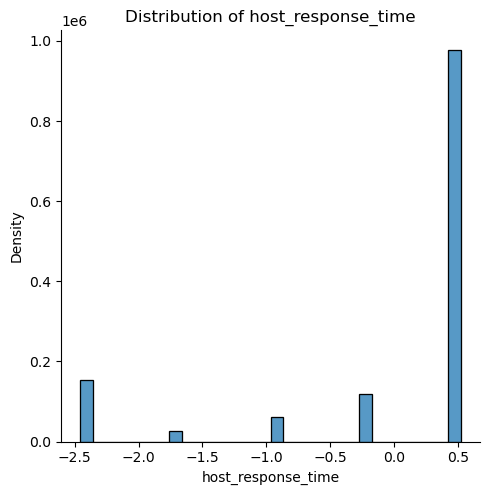

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x400 with 0 Axes>

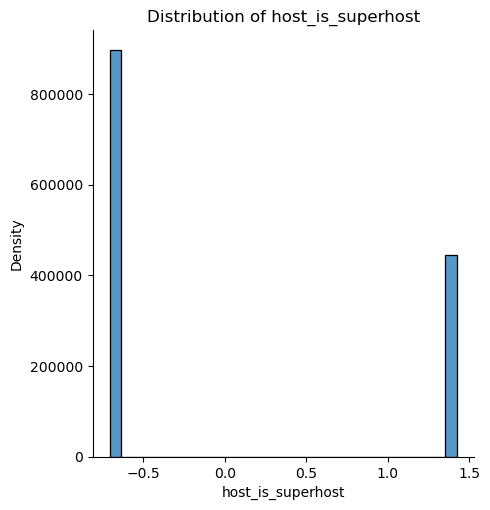

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x400 with 0 Axes>

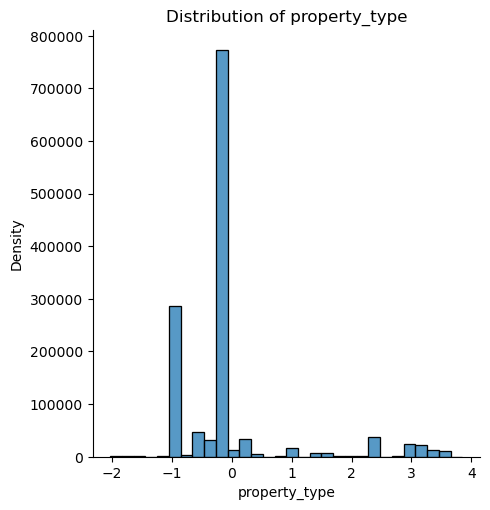

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x400 with 0 Axes>

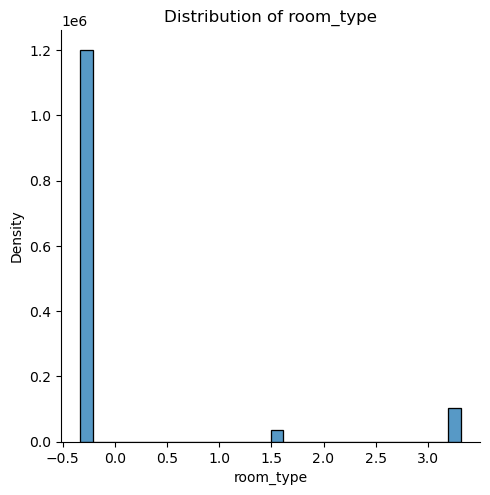

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x400 with 0 Axes>

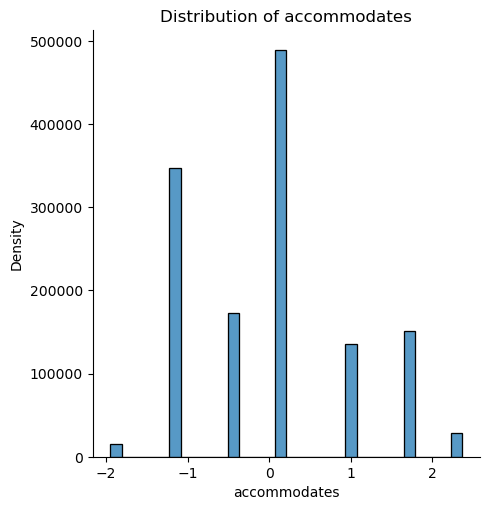

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x400 with 0 Axes>

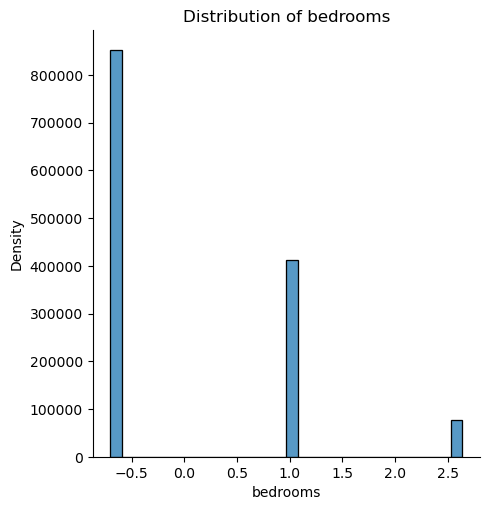

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x400 with 0 Axes>

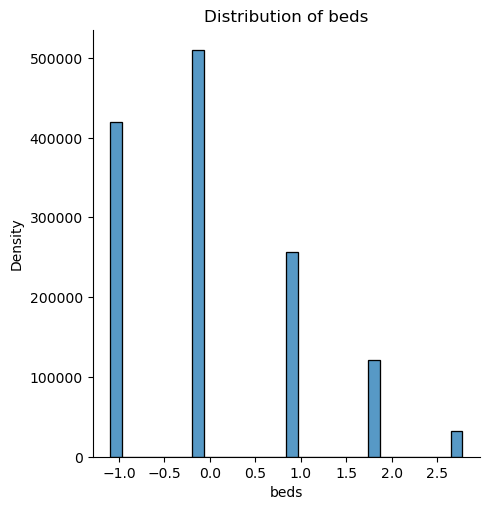

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x400 with 0 Axes>

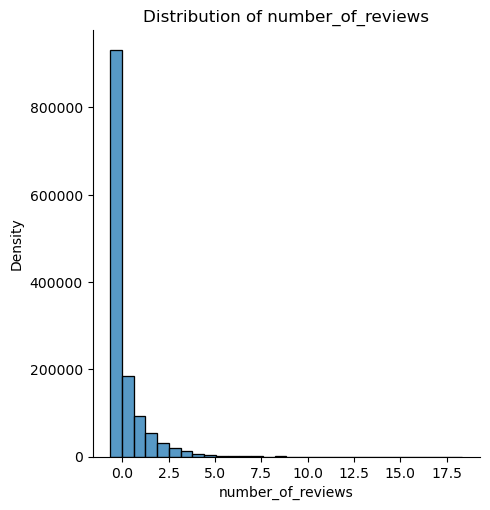

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x400 with 0 Axes>

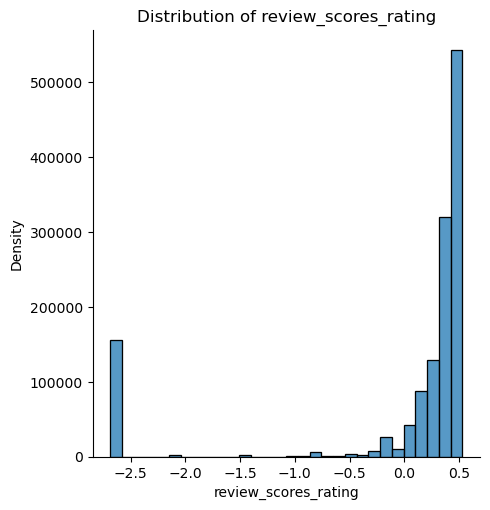

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x400 with 0 Axes>

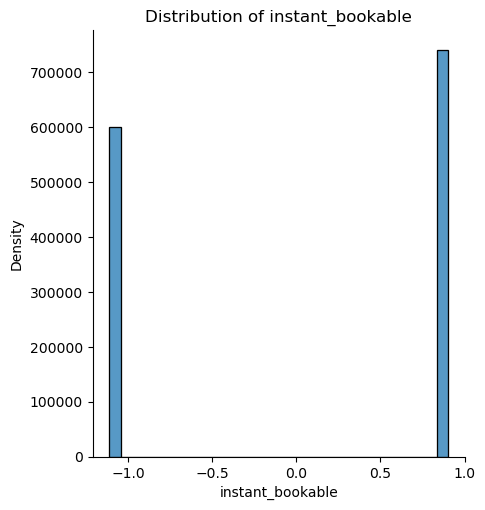

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x400 with 0 Axes>

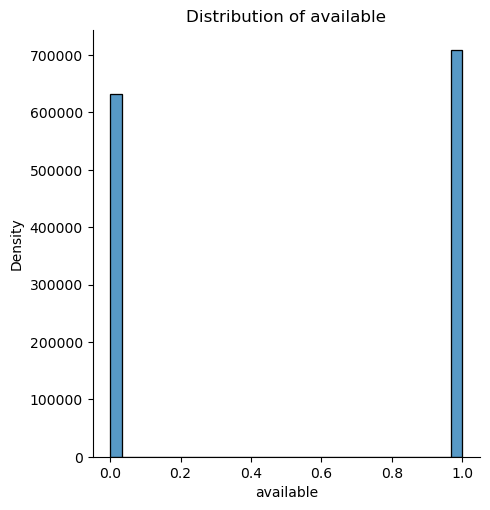

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x400 with 0 Axes>

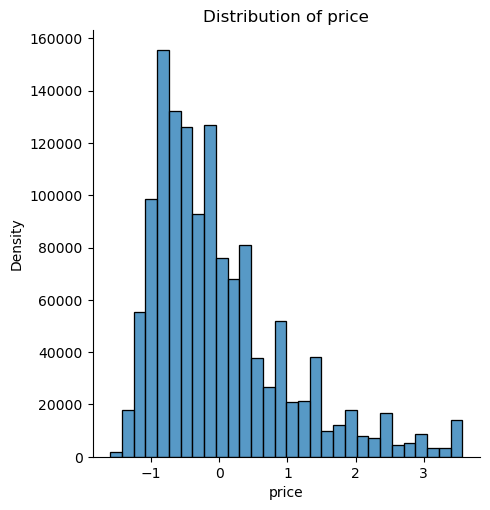

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x400 with 0 Axes>

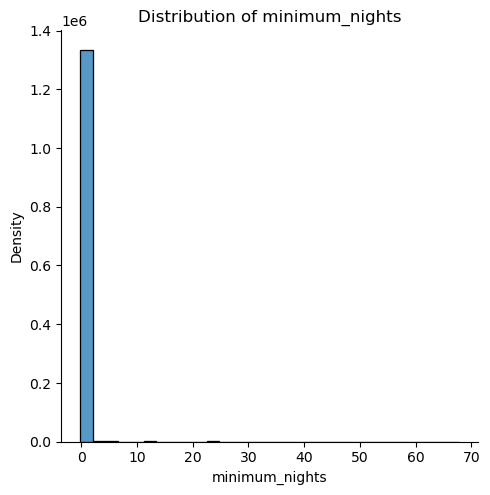

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x400 with 0 Axes>

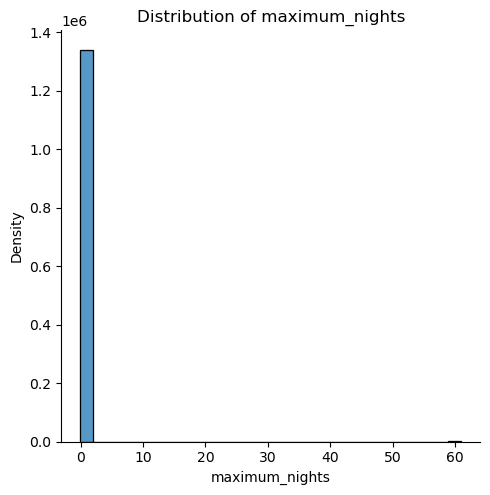

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x400 with 0 Axes>

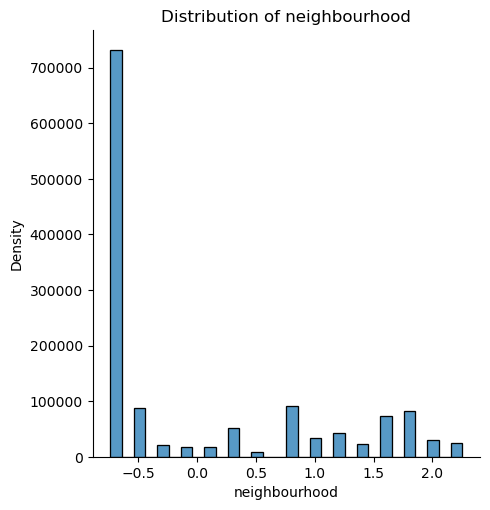

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x400 with 0 Axes>

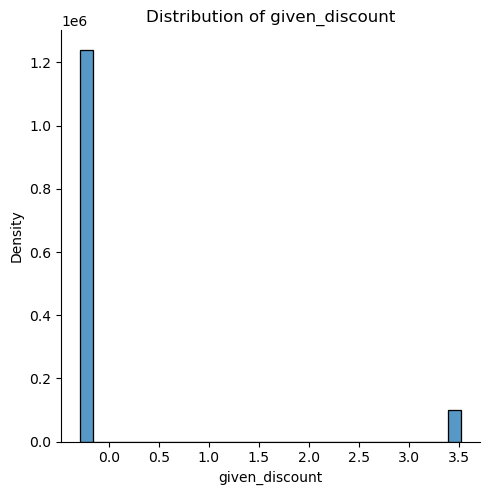

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x400 with 0 Axes>

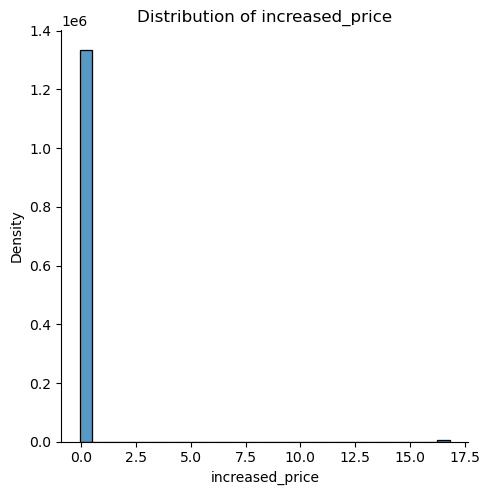

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x400 with 0 Axes>

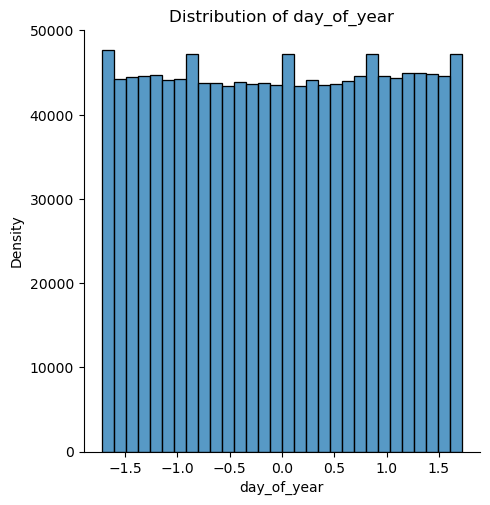

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x400 with 0 Axes>

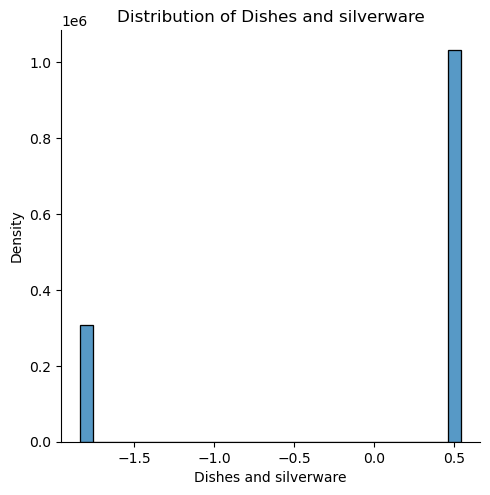

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x400 with 0 Axes>

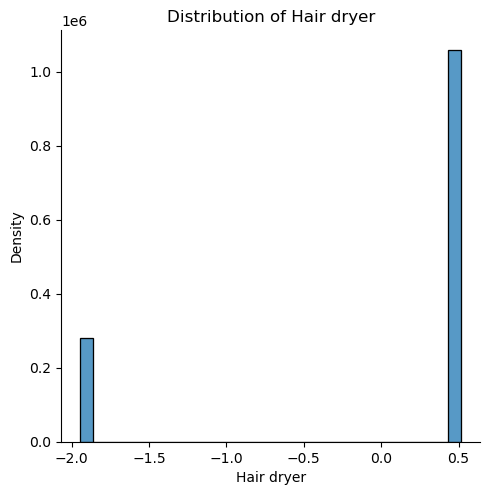

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x400 with 0 Axes>

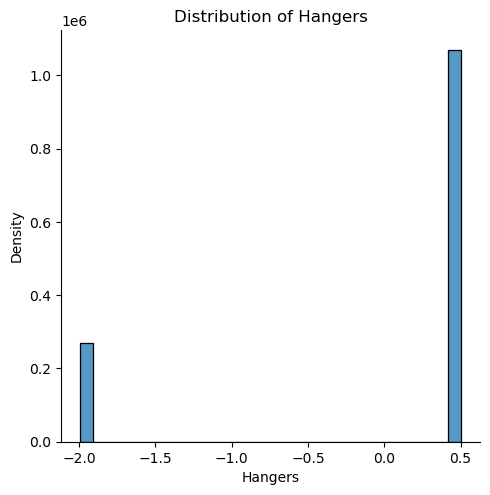

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x400 with 0 Axes>

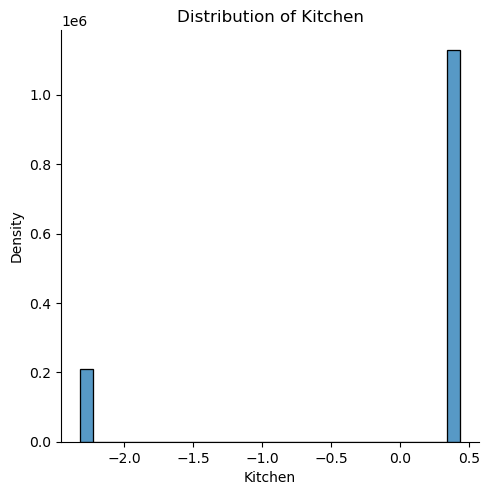

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x400 with 0 Axes>

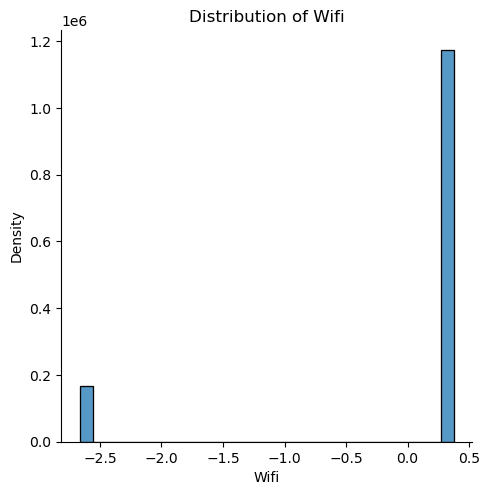

In [44]:
for column in rome_df.columns:
    plt.figure(figsize=(8, 4))
    sns.displot(rome_df[column], bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.show()

In [45]:
rome_df.info()
rome_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339994 entries, 0 to 1339993
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   host_response_time     1339994 non-null  float64
 1   host_is_superhost      1339994 non-null  float64
 2   property_type          1339994 non-null  float64
 3   room_type              1339994 non-null  float64
 4   accommodates           1339994 non-null  float64
 5   bedrooms               1339994 non-null  float64
 6   beds                   1339994 non-null  float64
 7   number_of_reviews      1339994 non-null  float64
 8   review_scores_rating   1339994 non-null  float64
 9   instant_bookable       1339994 non-null  float64
 10  available              1339994 non-null  int32  
 11  price                  1339994 non-null  float64
 12  minimum_nights         1339994 non-null  float64
 13  maximum_nights         1339994 non-null  float64
 14  neighbourhood     

,host_response_time,host_is_superhost,property_type,room_type,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,instant_bookable,available,price,minimum_nights,maximum_nights,neighbourhood,given_discount,increased_price,day_of_year,Dishes and silverware,Hair dryer,Hangers,Kitchen,Wifi
0,-0.965986,-0.703834,-0.992728,-0.328974,0.929552,0.967610,0.840444,-0.565882,0.132143,0.901188,1,-0.476031,0.051720,-0.016425,1.185510,-0.284087,-0.059455,-0.049132,0.544622,0.514786,0.502261,0.431254,0.375744
1,0.523365,-0.703834,-0.992728,-0.328974,0.209220,-0.704686,-1.096067,-0.642749,0.531464,0.901188,0,0.640334,-0.016435,-0.016434,-0.524892,-0.284087,-0.059455,0.783820,0.544622,0.514786,0.502261,0.431254,0.375744
2,0.523365,1.420790,-0.992728,-0.328974,0.929552,0.967610,0.840444,0.455358,0.428414,0.901188,1,0.050556,-0.084589,-0.016403,-0.738692,-0.284087,-0.059455,-1.497334,0.544622,0.514786,0.502261,0.431254,0.375744
3,0.523365,1.420790,-0.070159,-0.328974,0.209220,-0.704686,-1.096067,2.311159,0.196550,0.901188,0,1.461810,-0.084589,-0.016403,-0.738692,-0.284087,-0.059455,-0.219509,0.544622,0.514786,0.502261,0.431254,0.375744
4,0.523365,1.420790,-0.070159,-0.328974,0.209220,-0.704686,-1.096067,3.079834,0.364007,0.901188,0,0.408636,-0.016435,-0.016403,-0.738692,-0.284087,-0.059455,-1.686642,0.544622,0.514786,0.502261,0.431254,0.375744


## Splitting the dataframe

In [46]:
X = rome_df.drop('available', axis=1)  # Features
y = rome_df['available']  # Target variable

# Split the data into a training set and a test set (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Recursive Feature Elimination

In [47]:
# Initialize the logistic regression model
logreg = LogisticRegression()

# Initialize RFE with the logistic regression model and the desired number of features
rfe = RFE(logreg, n_features_to_select=20)

# Fit RFE
rfe = rfe.fit(X_train, y_train)

# Print the ranking of features
print("Feature ranking:", rfe.ranking_)

# Get the boolean mask for selected features
selected_features_mask = rfe.support_

# Select columns based on RFE support
selected_columns = X.columns[selected_features_mask]
print("Selected columns:", selected_columns.tolist())

# Create new train and test sets with only the selected features
X_train_selected = X_train[selected_columns]
X_test_selected = X_test[selected_columns]

Feature ranking: [1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 2]
Selected columns: ['host_response_time', 'host_is_superhost', 'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds', 'review_scores_rating', 'instant_bookable', 'price', 'minimum_nights', 'maximum_nights', 'neighbourhood', 'given_discount', 'increased_price', 'day_of_year', 'Dishes and silverware', 'Hair dryer', 'Hangers', 'Kitchen']


## Logistic regression model

In [48]:
# Initialize the logistic regression
logreg = LogisticRegression()

# Fit the model on training data
logreg.fit(X_train_selected, y_train)

# Using the test data independent variables to predict availability 
y_pred_logreg = logreg.predict(X_test_selected)

## K-Nearest Neighbors Model

### Convert the data to NumPy arrays

In [49]:
X_train_np = X_train_selected.to_numpy()
X_test_np = X_test_selected.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

### Cross-Validation to Find Optimal n_neighbors

best_score = 0
best_k = 1
scores_list = []

for k in range(1, 100):  # Adjust the range as needed
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_np, y_train_np, cv=5, n_jobs=-1)  # Using training data for cross-validation
    mean_score = scores.mean()
    scores_list.append(mean_score)

    if mean_score > best_score:
        best_score = mean_score
        best_k = k
        
# Print best K and its score
print(f"Best K: {best_k}, Score: {best_score}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(1, 100), scores_list, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Neighbors')
plt.xticks(range(1, 100))
plt.show()

### Stratified k-Fold Cross-Validation

best_score = 0
best_k = 1
scores_list = []

skf = StratifiedKFold(n_splits=5)  # You can adjust the number of splits

for k in range(1, 100):  # Adjust the range as needed
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_np, y_train_np, cv=skf, n_jobs=-1)  # Using StratifiedKFold
    mean_score = scores.mean()
    scores_list.append(mean_score)

    if mean_score > best_score:
        best_score = mean_score
        best_k = k

print(f"Best K: {best_k}, Score: {best_score}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(1, 100), scores_list, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Neighbors')
plt.xticks(range(1, 100))
plt.show()

### Leave-One-Out Cross-Validation

best_score = 0
best_k = 1
loo = LeaveOneOut()

for k in range(1, 100):  # Adjust the range as needed
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_np, y_train_np, cv=loo, n_jobs=-1)  # Using LeaveOneOut
    mean_score = scores.mean()

    if mean_score > best_score:
        best_score = mean_score
        best_k = k

print(f"Best K: {best_k}, Score: {best_score}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(range(1, 100), scores_list, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Neighbors')
plt.xticks(range(1, 100))
plt.show()

### Training KNN models with different parameters

In [50]:
knn = KNeighborsClassifier(n_neighbors=5, metric= "euclidean", weights = "uniform")
knn.fit(X_train_np, y_train_np)

y_pred_e_u = knn.predict(X_test_np)

In [51]:
knn = KNeighborsClassifier(n_neighbors=5, metric= "euclidean", weights = "distance")
knn.fit(X_train_np, y_train_np)

y_pred_e_d = knn.predict(X_test_np)

In [52]:
knn = KNeighborsClassifier(n_neighbors=5, metric= "manhattan", weights = "uniform")
knn.fit(X_train_np, y_train_np)

y_pred_m_u = knn.predict(X_test_np)

In [53]:
knn = KNeighborsClassifier(n_neighbors=5, metric= "manhattan", weights = "distance")
knn.fit(X_train_np, y_train_np)

y_pred_m_d = knn.predict(X_test_np)

### Analyzing KNN model's predictions

Accuracy for Euclidean Uniform: 0.9043018817234393
              precision    recall  f1-score   support

           0       0.90      0.89      0.90    126293
           1       0.90      0.92      0.91    141706

    accuracy                           0.90    267999
   macro avg       0.90      0.90      0.90    267999
weighted avg       0.90      0.90      0.90    267999

Accuracy for Euclidean Distance: 0.9266639054623338
              precision    recall  f1-score   support

           0       0.93      0.92      0.92    126293
           1       0.93      0.93      0.93    141706

    accuracy                           0.93    267999
   macro avg       0.93      0.93      0.93    267999
weighted avg       0.93      0.93      0.93    267999

Accuracy for Manhattan Uniform: 0.9159064026358308
              precision    recall  f1-score   support

           0       0.92      0.90      0.91    126293
           1       0.92      0.93      0.92    141706

    accuracy                

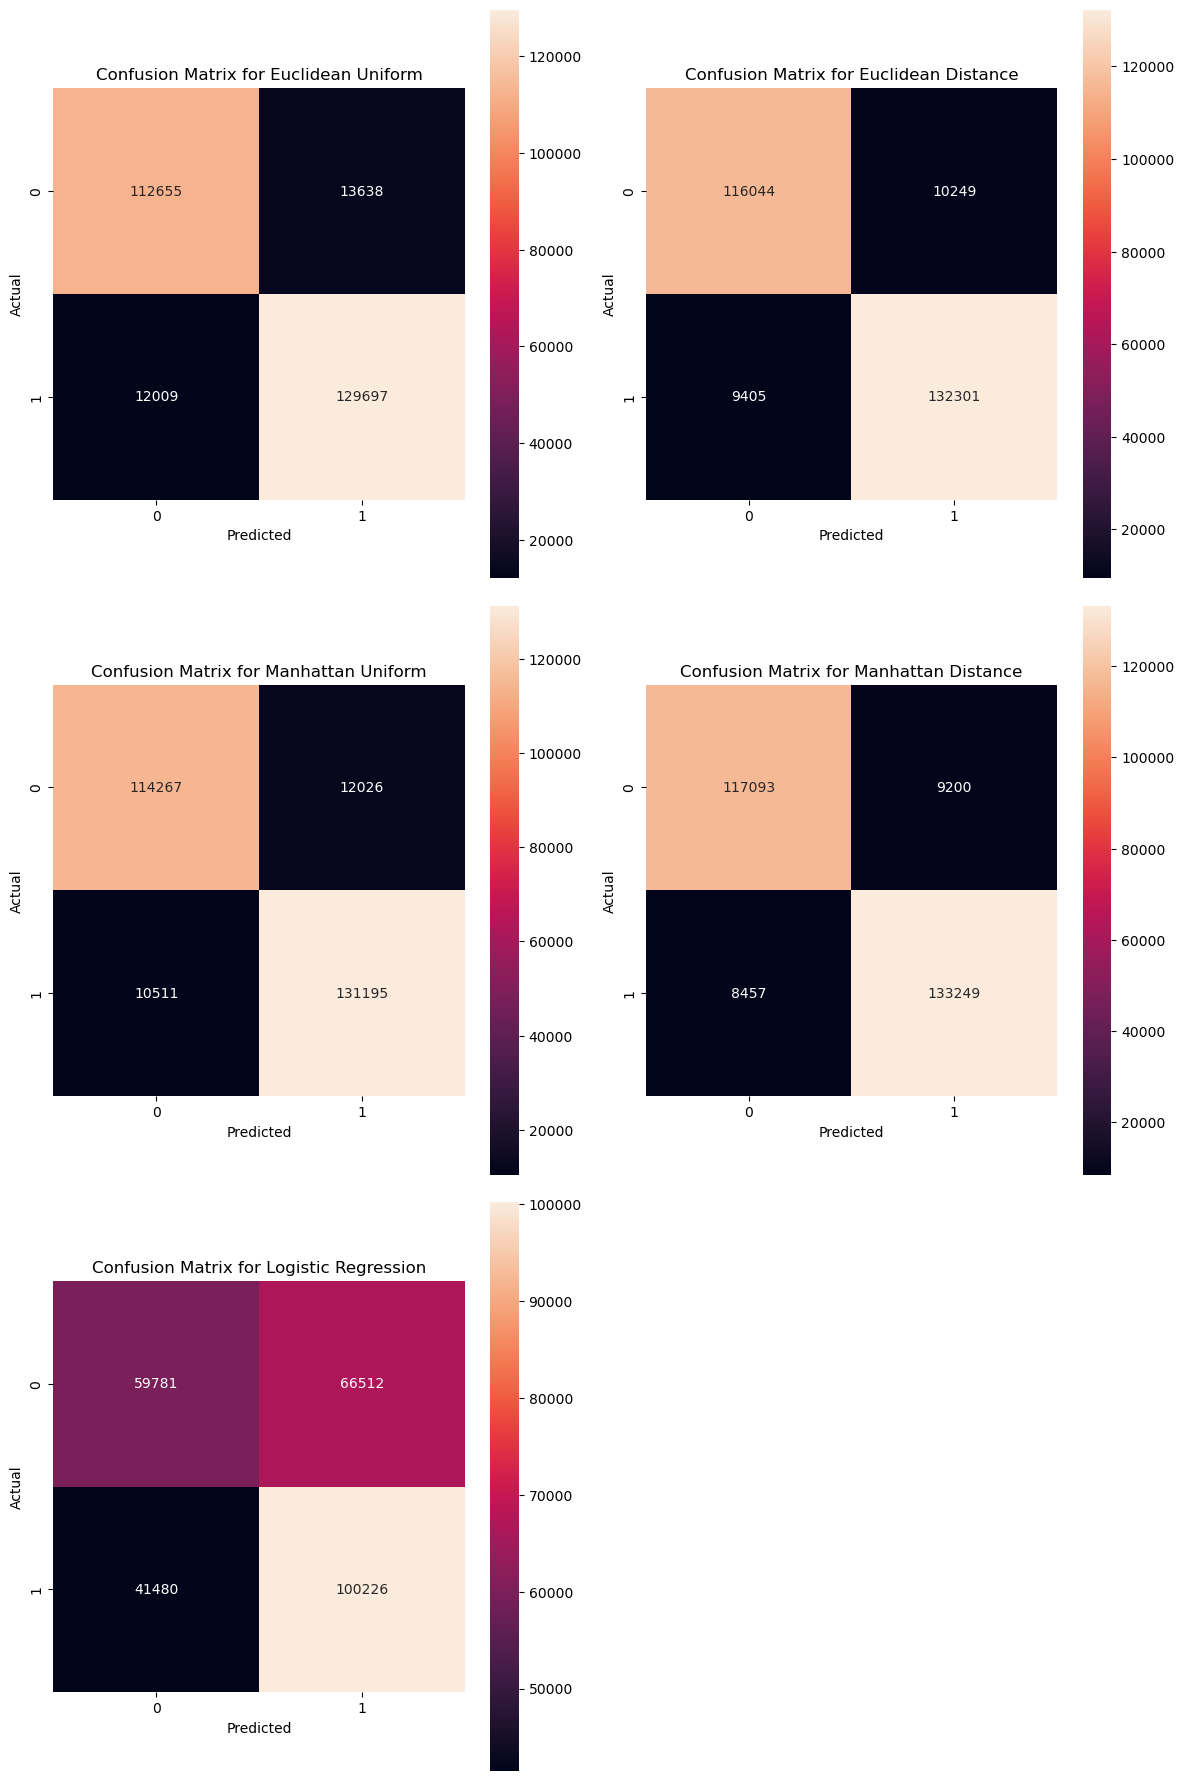

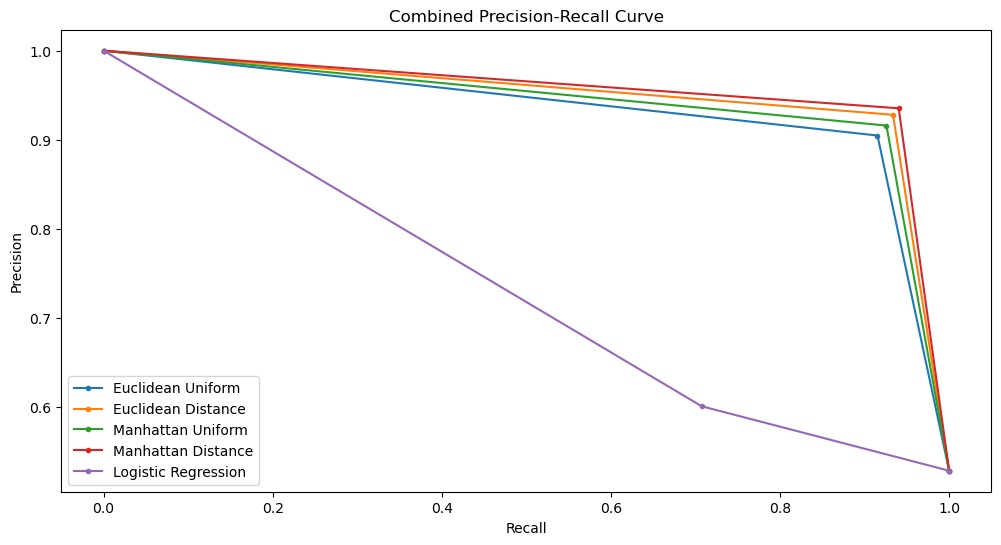

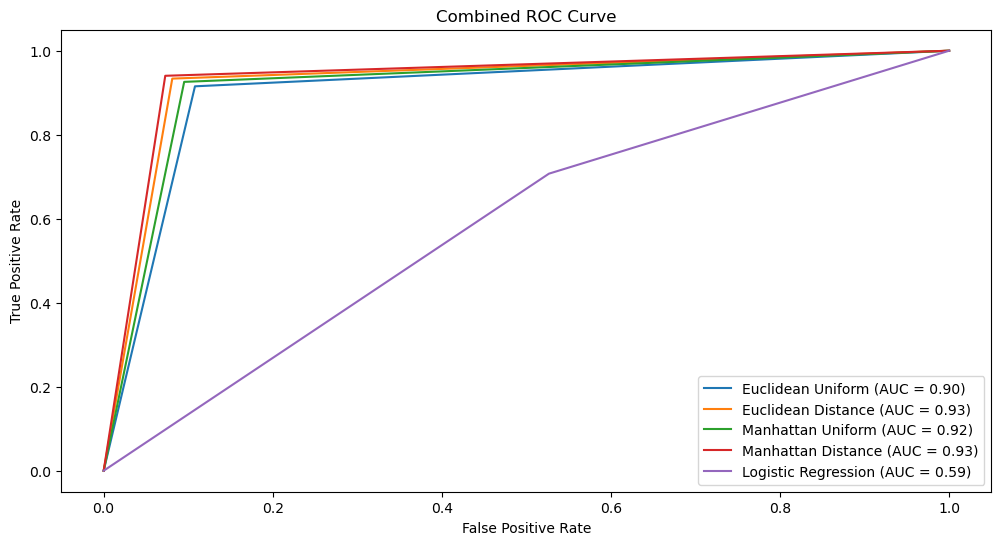

In [54]:
# y_pred_e_u, y_pred_e_d, y_pred_m_u, y_pred_m_d are the models predictions
models = [y_pred_e_u, y_pred_e_d, y_pred_m_u, y_pred_m_d, y_pred_logreg]
labels = ["Euclidean Uniform", "Euclidean Distance", "Manhattan Uniform", "Manhattan Distance", "Logistic Regression"]

# Loop to calculate and print accuracy for each model
for y_pred, label in zip(models, labels):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {label}: {accuracy}")
    print(classification_report(y_test, y_pred))

# Loop to generate and display confusion matrices for each model
plt.figure(figsize=(12, 18))
for i, (y_pred, label) in enumerate(zip(models, labels)):
    # Create confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.subplot(3, 2, i+1)  # 3x2 subplot grid
    sns.heatmap(conf_matrix, annot=True, fmt='g', square=True)
    plt.title(f'Confusion Matrix for {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))

# Precision-Recall Curves
for y_pred, label in zip(models, labels):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    plt.plot(recall, precision, marker='.', label=label)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Combined Precision-Recall Curve')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))

# ROC Curves
for y_pred, label in zip(models, labels):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curve')
plt.legend()
plt.show()